# Client 1 Electricity

### Imports

In [548]:
import warnings
import sys
import os.path
import math
sys.path.insert(0, os.path.abspath('../../../../functions'))
from knmi_weather import knmi_weather as knmi # eda tools
from sp_ql import Engine
import pandas as pd
import statistics
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from math import ceil
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
import joblib
import seaborn as sns
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

### Defs

In [549]:
def calc_soc_pos_on_plot(df_compare_monthly, soc):
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

### Clearing up EANs for NSI

In [550]:
project = 'NSI' #change to Merin, need to clean up their EANs at the bottom when available
engine=Engine(project=project, isAsync=False)
bms_registers = engine.list().filter(unit='CELCIUS').all()
build_names = bms_registers['keyname_01'].unique()
build_names = build_names[~pd.isna(build_names)]
build_names = np.delete(build_names,10) #new building, completely dropped, also from build_names P23584
#build_names = np.delete(build_names,9) #removes "PARI_ADM" blocky or missing data
build_names = np.delete(build_names,0) #removes "RADPAMS", no training data. SOC is before first recorded value on server
eans=pd.read_csv(f'/Users/Matt/Desktop/MSc/Thesis/Spectral/brighter_eda/inputs/eans/{project.lower()}_eans.csv')
#extraction of unique keyname_01 and EAN for electricity
electr_eans=eans[eans['Contract Type']=='Electricity']
electr_eans=electr_eans[['keyname_01', 'EAN']].dropna().set_index('keyname_01').squeeze()
#extraction of unique keyname_01 and EAN for gas

#adds missing buildings
for building in build_names:
    if building not in electr_eans.index:
        electr_eans[building]=np.nan
if project=="NSI":
    del electr_eans['FOKKERWG']
    del electr_eans['PARI_ADM']
    del electr_eans['P2639']
    del electr_eans['R003331'] #multiple EANs
    del electr_eans['AVS_UTR'] #two EANs -> added 27th April 2022
    del electr_eans['ROME_ADM']
    del electr_eans['P163063']
    del electr_eans['BENNEK43']
    del electr_eans['P23584']
    #nsi electricity
    electr_eans=electr_eans.append(pd.Series(index=['PARI_ADM'], data=['871685900041466814']))
    electr_eans=electr_eans.append(pd.Series(index=['FOKKERWG'], data=['871685900000028770']))
    #electr_eans=electr_eans.append(pd.Series(index=['P2639'], data=['871685900000028947']))
    electr_eans=electr_eans.append(pd.Series(index=['P163063'], data=['871685900000028947'])) #has same EAN as P26399
    electr_eans=electr_eans.append(pd.Series(index=['ROME_ADM'], data=['871685900000033477']))
    electr_eans=electr_eans.append(pd.Series(index=['AVS_UTR']*2, data=['871687400002070169','871687400002070138']))
    electr_eans=electr_eans.append(pd.Series(index=['R003331']*5, data=['871687400001086802','871687400002056224', '871687400002056231', '871687400008697070', '871687400009144542']))

In [551]:
# determine building location
cities = eans[['keyname_01', 'City']].dropna()
cities = cities.drop_duplicates().set_index('keyname_01').squeeze()
cities['P163063']='Amsterdam' #manually adding: Derkinderenstraat=P163063=Amsterdam
cities['RADPAMS_ALL']='Amsterdam' #change later
cities['RADPAMS']='Amsterdam' #change later
cities['R003331_ALL']='Amsterdam' #change later
cities['R003331']='Amsterdam' #change later
# read and preprocess weather data
knmi_station_lookup = pd.read_csv(r'../../../../inputs/knmi/knmi_uurgegevens/city_knmi_station_lookup.csv', index_col=0, squeeze=True)
#KeyError: "['RADPAMS_ALL', 'R003331_ALL', 'P23584', 'R003331', 'RADPAMS'] not in index"
t = cities.to_frame()
t = t[~t.index.duplicated(keep='first')]
cities=t.squeeze()

In [552]:
# read in start of control dates, just reads the file
socs = pd.read_csv(r'../../../../inputs/start_of_control/start_of_control_dates.csv')
socs = socs[socs['project']==project]
socs = socs.set_index('keyname_01')['soc_date'].squeeze()
socs = pd.to_datetime(socs)

In [555]:
data_periods = pd.DataFrame()
data_periods['end'] = socs[electr_eans.index]
data_periods['start'] = socs[electr_eans.index] - dt.timedelta(days=365) #more training data=better
data_periods = data_periods[~data_periods.index.duplicated(keep='first')]

In [567]:
build_names
#build_names=np.append(build_names, 'PARI_ADM')

array(['DIEMEN', 'FOKKERWG', 'BENNEK41', 'R003331', 'AVS_UTR', 'P163063',
       'ROME_ADM', 'PARI_ADM'], dtype=object)

In [557]:
#removes two buildings from build_names which have both no electricity and gas EAN data
build_names=np.delete(build_names, 5, axis=None)

In [561]:
build_names=np.delete(build_names, 8, axis=None)

In [566]:
build_names=np.delete(build_names, 6, axis=None)

### Electricity data pull

In [568]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h' # daily
electr_use = pd.DataFrame(index=pd.date_range(start=data_periods['start'].min(),
                                              end=data_periods['end'].max(),
                                              freq=time_res))

# pulls data from sp-ql
for building in build_names:
    start = data_periods.loc[building, 'start']
    end = data_periods.loc[building, 'end']
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use = electr_use.join(electr)
        else:
            print(fr'{building} - electricity EAN:{electr_eans[building]} not found')
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use = electr_use.join(electr)
            else:
                print(fr'{building} - electricity EAN:{ean} not found')

In [569]:
electr_use = electr_use.resample('d').sum() #sums the kWh to daily readings

### Grouping multiple EANs from R003331

In [570]:
filter_col = [col for col in electr_use if col.startswith('R003331')]
electr_use[filter_col]=electr_use[filter_col].fillna(0)
electr_use['R003331_ALL']=electr_use[filter_col].sum(axis=1)
electr_use['R003331_ALL']=electr_use['R003331_ALL'].replace({'0':np.nan, 0:np.nan})

### Grouping multiple EANs from AVS_UTR

In [571]:
filter_col = [col for col in electr_use if col.startswith('AVS_UTR')]
electr_use[filter_col]=electr_use[filter_col].fillna(0)
electr_use['AVS_UTR_ALL']=electr_use[filter_col].sum(axis=1)
electr_use['AVS_UTR_ALL']=electr_use['AVS_UTR_ALL'].replace({'0':np.nan, 0:np.nan})

### Clean-up of electr_use

In [572]:
electr_use=electr_use.drop(['R003331_871687400001086802',
                 'R003331_871687400002056224', 'R003331_871687400002056231', 'R003331_871687400008697070', 'R003331_871687400009144542',
                                           'AVS_UTR_871687400002070169','AVS_UTR_871687400002070138'], axis=1) #drops columns now grouped

In [573]:
electr_use.rename(columns = {'DIEMEN_871685900041463042':'DIEMEN', 'FOKKERWG_871685900000028770':'FOKKERWG', 'BENNEK41_871687120101437013':'BENNEK41', 
                                     'AVS_UTR_871687400002070169':'AVS_UTR', 'P163063_871685900000028947':'P163063', 'P2639_871685900000028947':'P2639',
                                    'ROME_ADM_871685900000033477':'ROME_ADM', 'PARI_ADM_871685900041466814':'PARI_ADM',
                                    'R003331_ALL':'R003331', 'AVS_UTR_ALL':'AVS_UTR'}, inplace = True)

In [574]:
weather = {}
for station in knmi_station_lookup.unique():
    knmi_weather_file_1 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2011-2020.txt'
    knmi_weather_file_2 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2021-2030.txt'
    knmi_weather = pd.read_csv(knmi_weather_file_1,
                               skiprows=31,
                               skipinitialspace=True,
                               usecols=list(range(1, 25)))
    knmi_weather = knmi_weather.append(pd.read_csv(knmi_weather_file_2,
                                                   skiprows=31,
                                                   skipinitialspace=True,
                                                   usecols=list(range(1, 25))))
    # making proper index for KNMI weather data
    knmi_weather.index = knmi.convert_knmi_dates(date=knmi_weather['YYYYMMDD'],
                                                 hour=knmi_weather['HH'])
    # clean up values
    knmi_weather = knmi.cleanup_knmi_units(knmi_weather=knmi_weather)
    weather[station] = knmi_weather

### Cleanup of electr_use df

In [575]:
electr_use.rename(columns = {'AVS_UTR_871687400002070169':'AVS_UTR', 'P163063_871685900000028947':'P163063', 'ROME_ADM_871685900000033477':'ROME_ADM', 
                                     'RADPAMS_ALL':'RADPAMS', 'R003331_ALL':'R003331', 'DIEMEN_871685900041463042':'DIEMEN',
                                     'BENNEK41_871687120101437013':'BENNEK41', 'FOKKERWG_871685900000028770':'FOKKERWG',
                                    'P2639_871685900000028947':'P2639','PARI_ADM_871685900041466814':'PARI_ADM'}, inplace = True)

In [579]:
## Determine training and prediction intervals
train_periods = pd.DataFrame()
train_periods['end'] = socs[electr_use.columns]
train_periods['start'] = socs[electr_use.columns] - dt.timedelta(days=365) #more training data=better
train_periods = train_periods[~train_periods.index.duplicated(keep='first')]
train_periods['start'][1]=train_periods['start'][1]+dt.timedelta(days=60) #moving training_period forward 2 months for FOKKERWG
train_periods['start'][7]=train_periods['start'][7]+dt.timedelta(days=60) #same for AVS_UTR
train_periods['start'][6]=train_periods['start'][6]+dt.timedelta(days=60) #same for R003331
train_periods['start'][5]=train_periods['start'][5]+dt.timedelta(days=60) #same for PARI_ADM
train_periods

,end,start
DIEMEN,2021-10-26,2020-10-26
FOKKERWG,2021-10-18,2020-12-17
BENNEK41,2021-10-21,2020-10-21
P163063,2021-12-21,2020-12-21
ROME_ADM,2021-12-15,2020-12-15
PARI_ADM,2021-12-15,2021-02-13
R003331,2021-11-22,2021-01-21
AVS_UTR,2021-10-19,2020-12-18


In [580]:
electr_use.to_csv(r'NSI_electr/data/electr_use_train.csv')

In [581]:
# some buildings have small gaps in gas data. We can interpolate over these
electr_use_train = pd.read_csv(r'NSI_electr/data/electr_use_train.csv', index_col=0,
                            parse_dates=True)

In [582]:
for building in electr_use.columns:
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    electr_use_train_build = electr_use_train.loc[start_train:end_train, building]
    #setting first element to 0 if nan. To aid interpolation.
    if electr_use_train_build.iloc[[0]].isna()[0]:
        electr_use_train_build.iloc[0] = 0
    electr_use_train_build = electr_use_train_build.interpolate(limit=10) # filling max 10 consecutive days of missing data?
    electr_use_train.loc[start_train:end_train, building] = electr_use_train_build

### RF Model

In [583]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()

    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    
    electr_use_train_build = electr_use[building]
    
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False) # cv --> Kfold 10 with shuffle - because my data is in order (if I would randomize the order then this would not be necessary)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'NSI_electr/data/trained_models/rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_electr/data/trained_models/rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_electr/data/trained_models/rf/y_test_{building}.joblib')

Training building DIEMEN, 1/8
Training building FOKKERWG, 2/8
Training building BENNEK41, 3/8
Training building P163063, 4/8
Training building ROME_ADM, 5/8
Training building PARI_ADM, 6/8
Training building R003331, 7/8
Training building AVS_UTR, 8/8


### Gradient Boosting

In [584]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()

    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek

    electr_use_train_build = electr_use[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]

    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)

    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }
    
    rf = GradientBoostingRegressor()
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    
    joblib.dump(grid_search.best_estimator_, fr'NSI_electr/data/trained_models/gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_electr/data/trained_models/gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_electr/data/trained_models/gb/y_test_{building}.joblib')

Training building DIEMEN, 1/8
Training building FOKKERWG, 2/8
Training building BENNEK41, 3/8
Training building P163063, 4/8
Training building ROME_ADM, 5/8
Training building PARI_ADM, 6/8
Training building R003331, 7/8
Training building AVS_UTR, 8/8


### Model: XGBoosting

In [585]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()
    
    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek

    electr_use_train_build = electr_use[building]
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'NSI_electr/data/trained_models/xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_electr/data/trained_models/xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_electr/data/trained_models/xg/y_test_{building}.joblib')

Training building DIEMEN, 1/8
Training building FOKKERWG, 2/8
Training building BENNEK41, 3/8
Training building P163063, 4/8
Training building ROME_ADM, 5/8
Training building PARI_ADM, 6/8
Training building R003331, 7/8
Training building AVS_UTR, 8/8


In [586]:
importance={}
for building in electr_use.columns:
    models = os.listdir('NSI_electr/data/trained_models/xg') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'NSI_electr/data/trained_models/xg/trained_{building}.joblib') #change for RF, GB, XG
        importance[building]=grid_search.feature_importances_
importance_df=pd.concat({k: pd.DataFrame(v) for k, v in importance.items()}, axis=1)
importance_df['mean'] = importance_df.mean(axis=1)
importance_df.insert(0, 'FEATURE', features.columns)
importance_df=importance_df.set_index(importance_df.columns[0])
importance_df=importance_df.sort_values(by=['mean'],ascending=False)
importance_df

,DIEMEN,FOKKERWG,BENNEK41,P163063,ROME_ADM,PARI_ADM,R003331,AVS_UTR,mean
,0,0,0,0,0,0,0,0,
"(FEATURE, )",,,,,,,,,
dow,0.947301,0.945240,0.952183,0.904588,0.841317,0.866051,0.928827,0.952492,0.917250
daily_mean_OAT,0.012649,0.020512,0.022653,0.033410,0.048487,0.048556,0.052237,0.019044,0.032194
daily_sum_GHI,0.023546,0.015214,0.015539,0.044417,0.054800,0.056590,0.010998,0.016652,0.029719
SQ,0.016503,0.019034,0.009625,0.017585,0.055396,0.028803,0.007938,0.011812,0.020837


In [835]:
# reading in saved trained RF models and calculating mae for the test set
mae_range_percent = pd.Series()
for building in electr_use.columns:
    models = os.listdir('NSI_electr/data/trained_models/rf') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        
        grid_search = joblib.load(fr'NSI_electr/data/trained_models/rf/trained_{building}.joblib') #change for RF, GB, XG
        X_test = joblib.load(fr'NSI_electr/data/trained_models/rf/X_test_{building}.joblib') #change for RF, GB, XG
        y_test = joblib.load(fr'NSI_electr/data/trained_models/rf/y_test_{building}.joblib') #change for RF, GB, XG
    #
    # grid search already contains the re-trained model with the best parameters
    y_test_pred = grid_search.predict(X_test)
    #
    # calculating MAE and plotting test and pred_test
    mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    # mae in percent of range
    mae_range_percent[building] = mae / y_test.max() * 100
    
    electr_use_train_build = electr_use[building]

In [836]:
statistics.mean(mae_range_percent)

5.023683112162784

### Metrics together - MAE

In [837]:
metric_com_mae = pd.DataFrame(index=electr_use.columns)

regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'NSI_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        electr_use_train_build = electr_use[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

### Metrics together - RMSE

In [838]:
metric_com_rmse = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'NSI_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

### Stacked ensembling - MAE

In [839]:
en_mae = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'NSI_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]
    

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent
    
print(en_mae)

                EN
DIEMEN    3.648145
FOKKERWG  3.493799
BENNEK41  3.185773
P163063   5.440384
ROME_ADM  3.268907
PARI_ADM  4.025811
R003331   3.230038
AVS_UTR   3.874404


In [840]:
en_mae.mean()

EN    3.770908
dtype: float64

### Ensemble stacked - MAE

In [841]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                RF        GB        XG        EN
DIEMEN    4.724445  5.350418  5.126418  3.648145
FOKKERWG  5.254321  5.790845  4.128070  3.493799
BENNEK41  4.546089  5.751680  5.674617  3.185773
P163063   6.171980  9.409687  5.916747  5.440384
ROME_ADM  5.359969  5.372708  5.086177  3.268907
PARI_ADM  4.866342  7.623001  4.774547  4.025811
R003331   4.382872  5.244985  3.729154  3.230038
AVS_UTR   4.883446  5.480415  5.462703  3.874404


Average MAEs


RF    5.02368
GB    6.25297
XG    4.98730
EN    3.77091
dtype: float64

### Stacked ensembling - RMSE

In [842]:
en_rmse = pd.DataFrame(index=electr_use.columns) #verander naam van variabele
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'NSI_electr/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent


### Ensemble effort - RMSE

In [843]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                 RF         GB         XG        EN
DIEMEN     6.616647   6.773483   6.650670  4.592592
FOKKERWG   8.130777   8.847277   5.510356  4.717319
BENNEK41   5.836667   8.799398  10.123772  4.987214
P163063   10.460453  14.945817   9.921437  7.407749
ROME_ADM   7.587632   7.067147   7.520709  4.612842
PARI_ADM   6.629574  10.960788   6.627188  5.484198
R003331    6.547102   7.080430   5.375404  4.282009
AVS_UTR    7.217836   8.040742   8.719100  5.520112


Average RMSEs


RF    7.37834
GB    9.06439
XG    7.55608
EN    5.20050
dtype: float64

# All models

In [878]:
electr_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in electr_use.columns:
        # select weather data for prediction
        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]
        # preapare features for prediction
        features = pd.DataFrame()
        features['SQ'] = knmi_weather['SQ'].resample('d').mean()
        features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
        features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
        features['dow'] = features.index.dayofweek
        #features['month'] = features.index.month
        X_pred = features #using KNMI weather data 2011-2022/04 and the trained model, predictions are made on energy consumption
        # do the predictions
        models = os.listdir(f'NSI_electr/data/trained_models/{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        electr_use_pred[building+'_'+m] = y_pred #gives energy consumption for model for building 2011-2022
        #print(electr_use_pred)

In [879]:
#ensemble stacking, equal weight
electr_use_pred['DIEMEN_en']=(electr_use_pred['DIEMEN_rf']+electr_use_pred['DIEMEN_gb']+electr_use_pred['DIEMEN_xg'])/3
electr_use_pred['FOKKERWG_en']=(electr_use_pred['FOKKERWG_rf']+electr_use_pred['FOKKERWG_gb']+electr_use_pred['FOKKERWG_xg'])/3
electr_use_pred['BENNEK41_en']=(electr_use_pred['BENNEK41_rf']+electr_use_pred['BENNEK41_gb']+electr_use_pred['BENNEK41_xg'])/3
electr_use_pred['P163063_en']=(electr_use_pred['P163063_rf']+electr_use_pred['P163063_gb']+electr_use_pred['P163063_xg'])/3
electr_use_pred['ROME_ADM_en']=(electr_use_pred['ROME_ADM_rf']+electr_use_pred['ROME_ADM_gb']+electr_use_pred['ROME_ADM_xg'])/3
electr_use_pred['PARI_ADM_en']=(electr_use_pred['PARI_ADM_rf']+electr_use_pred['PARI_ADM_gb']+electr_use_pred['PARI_ADM_xg'])/3
electr_use_pred['R003331_en']=(electr_use_pred['R003331_rf']+electr_use_pred['R003331_gb']+electr_use_pred['R003331_xg'])/3
electr_use_pred['AVS_UTR_en']=(electr_use_pred['AVS_UTR_rf']+electr_use_pred['AVS_UTR_gb']+electr_use_pred['AVS_UTR_xg'])/3

### Deeper comparison of all 3 models

In [880]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                              end=knmi_weather.index[-1],
                                              freq=time_res))
# pulls data from sp-ql
for building in build_names:
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use_meas = electr_use_meas.join(electr)
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use_meas = electr_use_meas.join(electr)

In [881]:
electr_use_meas = electr_use_meas.resample('d').sum()
filter_col = [col for col in electr_use_meas if col.startswith('R003331')]
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0)
electr_use_meas['R003331_ALL']=electr_use_meas[filter_col].sum(axis=1)
electr_use_meas['R003331_ALL']=electr_use_meas['R003331_ALL'].replace({'0':np.nan, 0:np.nan})
filter_col = [col for col in electr_use_meas if col.startswith('AVS_UTR')]
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0)
electr_use_meas['AVS_UTR_ALL']=electr_use_meas[filter_col].sum(axis=1)
electr_use_meas['AVS_UTR_ALL']=electr_use_meas['AVS_UTR_ALL'].replace({'0':np.nan, 0:np.nan})
electr_use_meas=electr_use_meas.drop(['R003331_871687400001086802',
                 'R003331_871687400002056224', 'R003331_871687400002056231', 'R003331_871687400008697070', 'R003331_871687400009144542',
                                           'AVS_UTR_871687400002070169','AVS_UTR_871687400002070138'], axis=1) #drops columns now grouped
electr_use_meas.rename(columns = {'DIEMEN_871685900041463042':'DIEMEN_rf', 'FOKKERWG_871685900000028770':'FOKKERWG_rf', 'BENNEK41_871687120101437013':'BENNEK41_rf', 
                                     'AVS_UTR_871687400002070169':'AVS_UTR_rf', 'P163063_871685900000028947':'P163063_rf', 'P2639_871685900000028947':'P2639_rf',
                                    'ROME_ADM_871685900000033477':'ROME_ADM_rf', 'PARI_ADM_871685900041466814':'PARI_ADM_rf',
                                    'R003331_ALL':'R003331_rf', 'AVS_UTR_ALL':'AVS_UTR_rf'}, inplace = True)


In [882]:
for m in ['gb','xg']:
    for building in electr_use.columns:
        electr_use_meas[building+"_"+m]=electr_use_meas[building+"_rf"]

In [890]:
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()

for m in ['rf','gb','xg']:
    for building in electr_use_meas.columns:
        size = len(building)
        start = train_periods.loc[building[:size-3], 'start']
        end = knmi_weather.index[-1]
        soc = socs[building[:size-3]]
        electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('d').sum()
        electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('d').sum()
        month_saving = (electr_use_pred_m - electr_use_meas_m) / electr_use_pred_m * 100
        month_savings[building] = month_saving
        month_savings_m3[building] = electr_use_pred_m - electr_use_meas_m
        total_savings_m3[building] = (electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum()
        #print(electr_use_pred.loc[soc:, building])
        total_savings_perc[building] = total_savings_m3[building] / electr_use_pred.loc[soc:, building].sum() * 100

train_pred_mae = pd.Series()
for m in ['rf','gb','xg']:
    for building in electr_use_meas.columns:
        size = len(building)
        soc = socs[building[:size-3]]
        start = train_periods.loc[building[:size-3], 'start']
        end = train_periods.loc[building[:size-3], 'end'] #knmi_weather.index[-1]
        electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('d').sum()
        electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('d').sum()
        electr_use_month_mae = mean_absolute_error(y_true=electr_use_meas_m, y_pred=electr_use_pred_m)
        train_pred_mae[building] = electr_use_month_mae

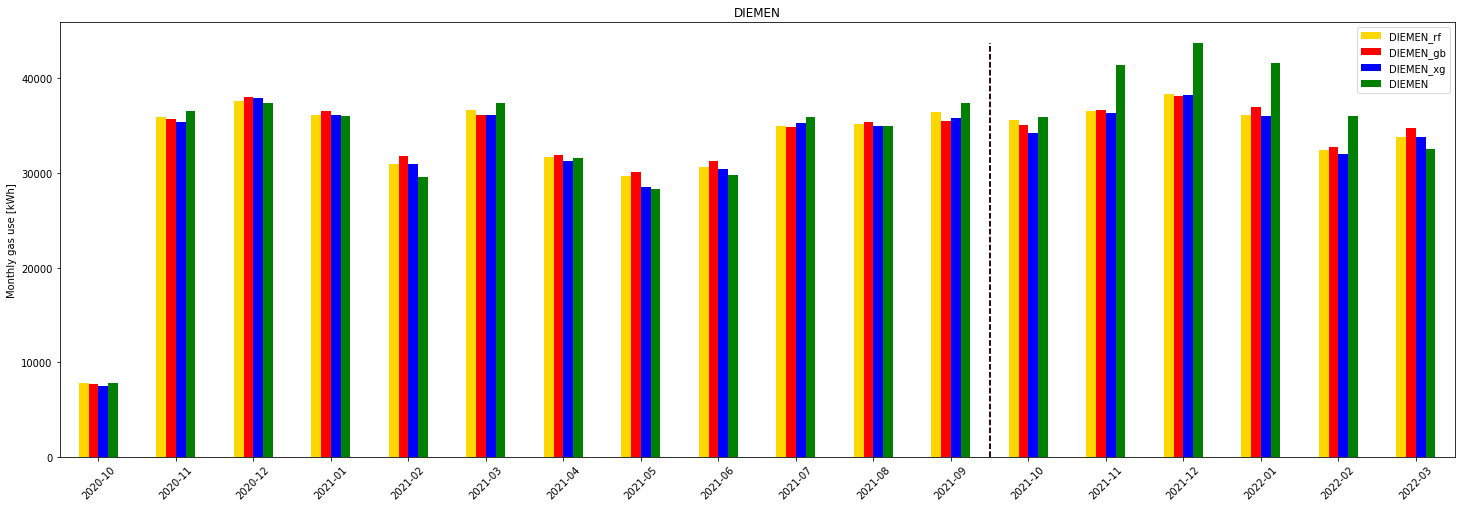

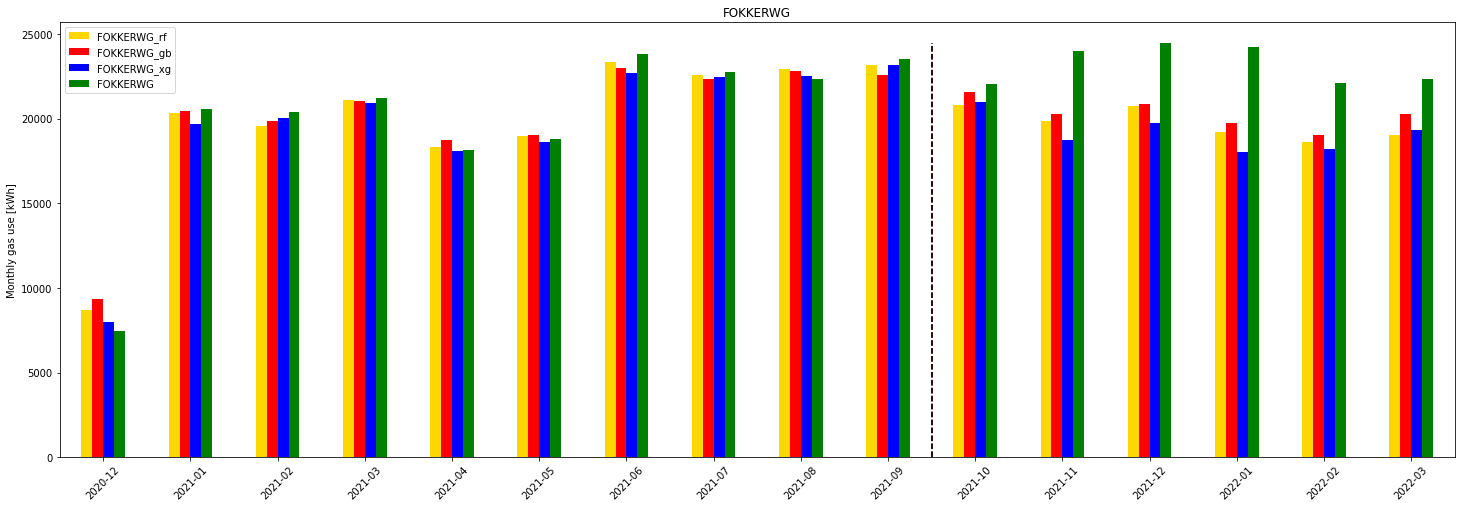

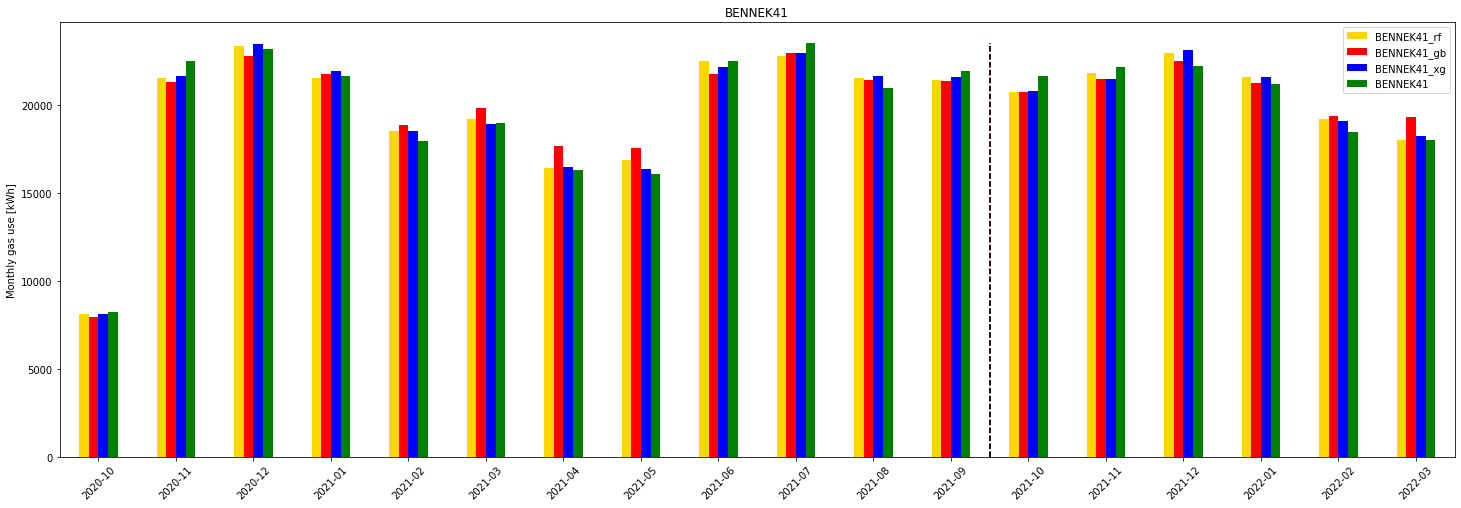

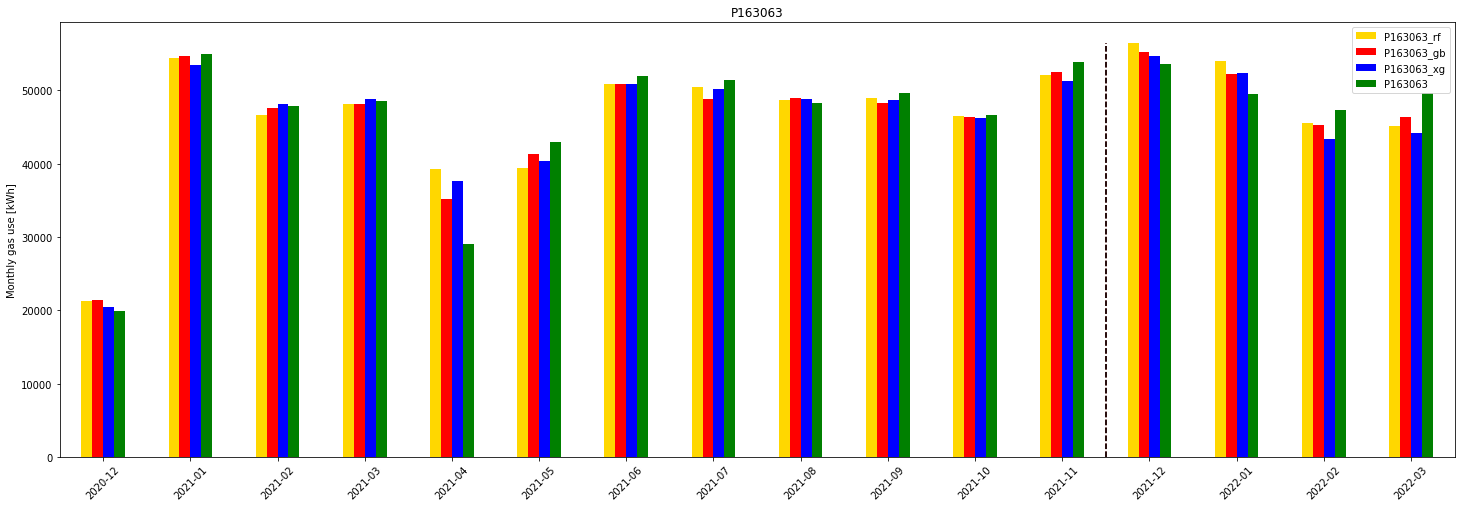

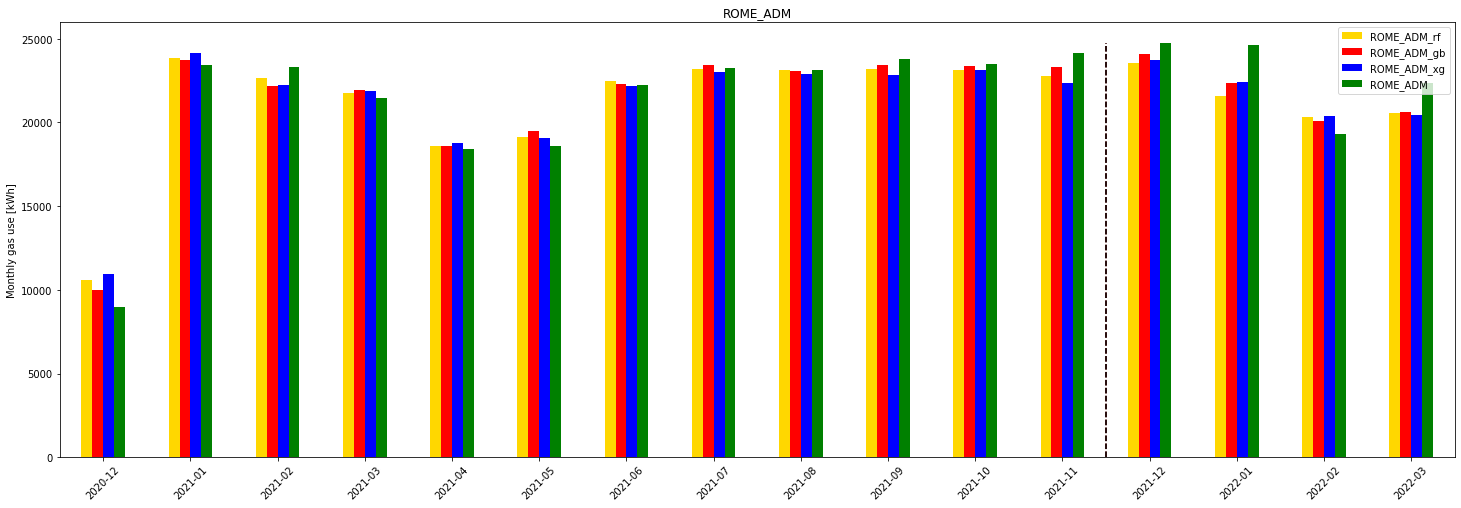

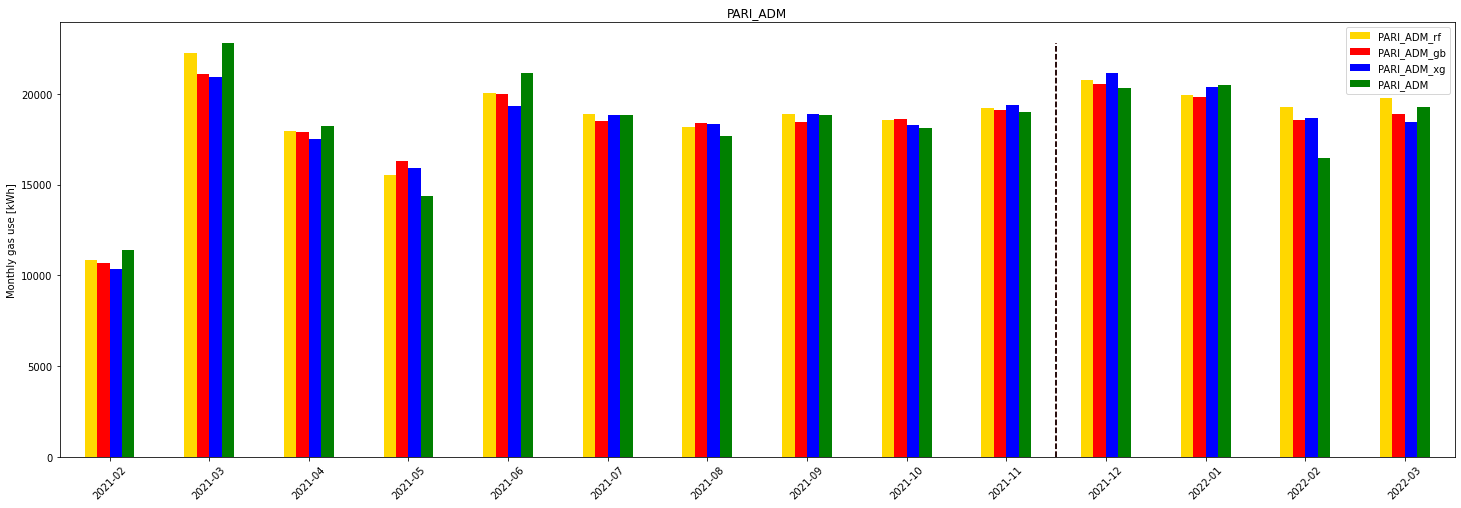

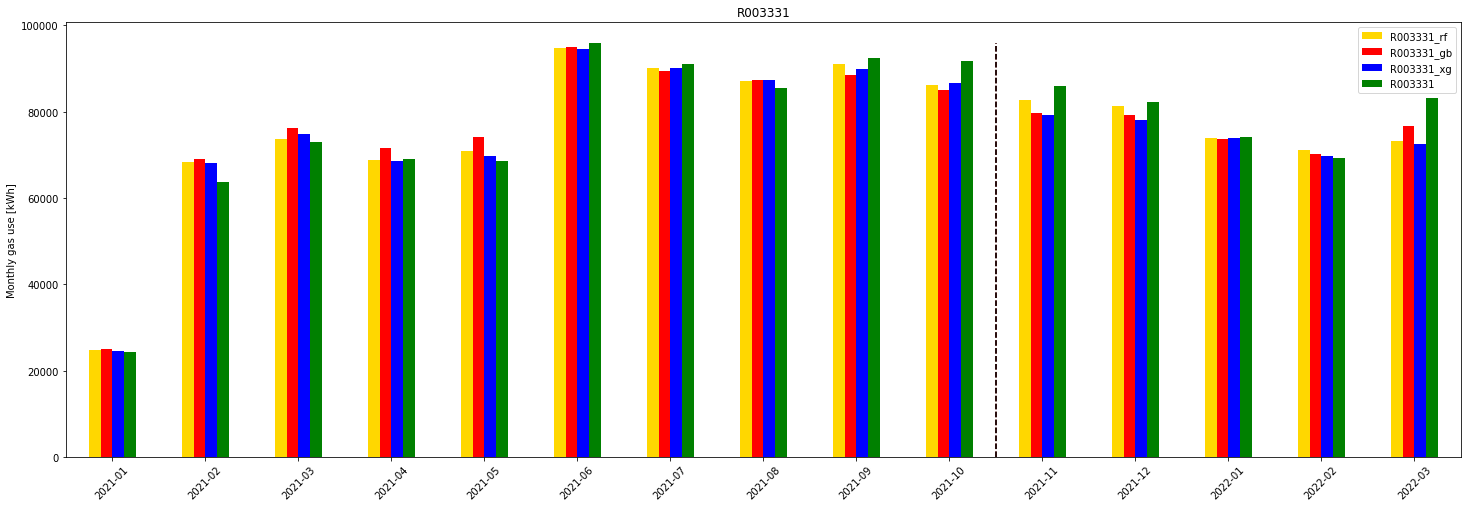

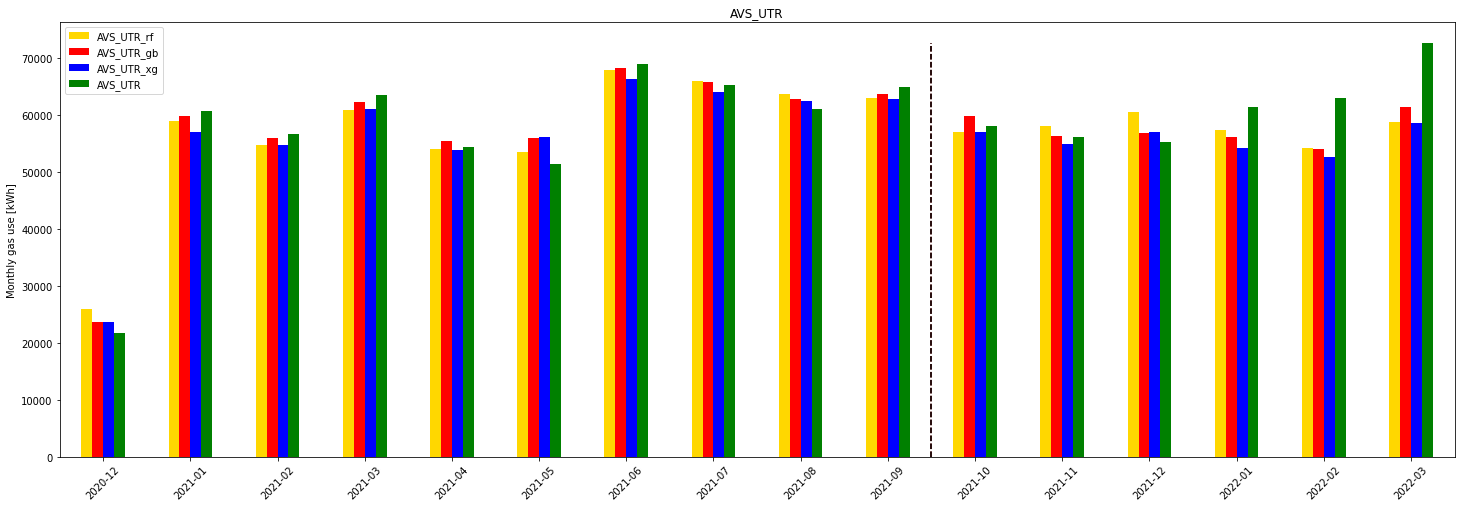

In [888]:
for building in electr_use.columns:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare2 = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(electr_use_pred[[building+"_rf"]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pre_rf'})
    df_compare = df_compare.join(electr_use_pred[[building+"_gb"]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pred_gb'})
    df_compare = df_compare.join(electr_use_pred[[building+"_xg"]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pred_xg'})
    df_compare2 = df_compare2.join(electr_use_meas
                                   [[building+"_rf"]])
    df_compare2 = df_compare2.rename(columns={building:fr'{building}'})
    df_compare2.rename(columns = {f'{building}_rf':f'{building}'}, inplace = True)
    df_compare=pd.concat([df_compare, df_compare2])

    
    #
    df_compare = df_compare.resample('m').sum()
    soc = socs[building]#.date()
    soc_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=soc)
    
    train_end_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=train_periods.loc[building, 'end'])
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    #err = pd.DataFrame(index=df_compare.index, data={fr'{building}_pred':train_pred_mae[building]})
    #err.iloc[:int(soc_pos) + 1] = np.nan
    df_compare.plot.bar(ax=ax, color=['gold', 'red', 'blue', 'green'], 
                        error_kw=dict(ecolor='darkred', lw=1, capsize=2, capthick=3))
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]
    plt.ylabel('Monthly gas use [kWh]')
    plt.title(building)
    plt.show(block=False)

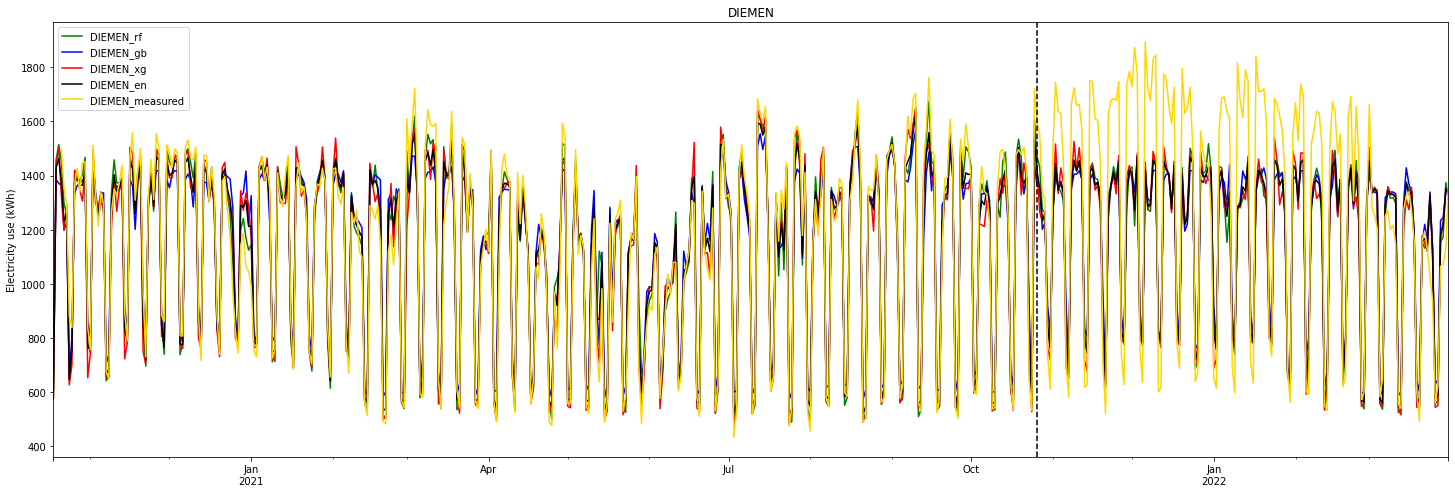

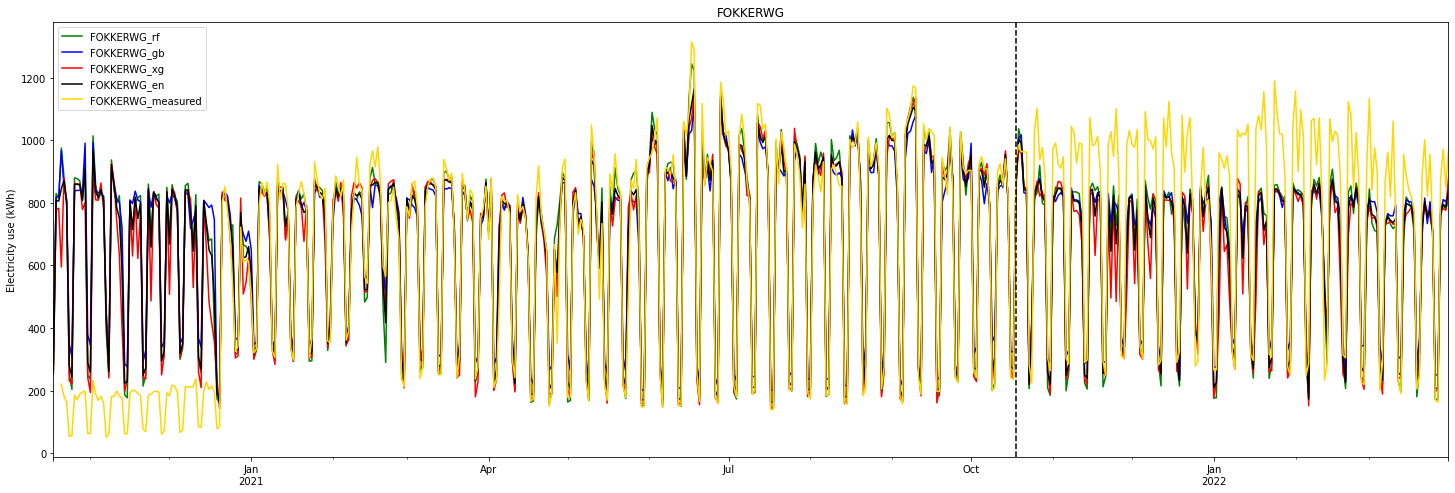

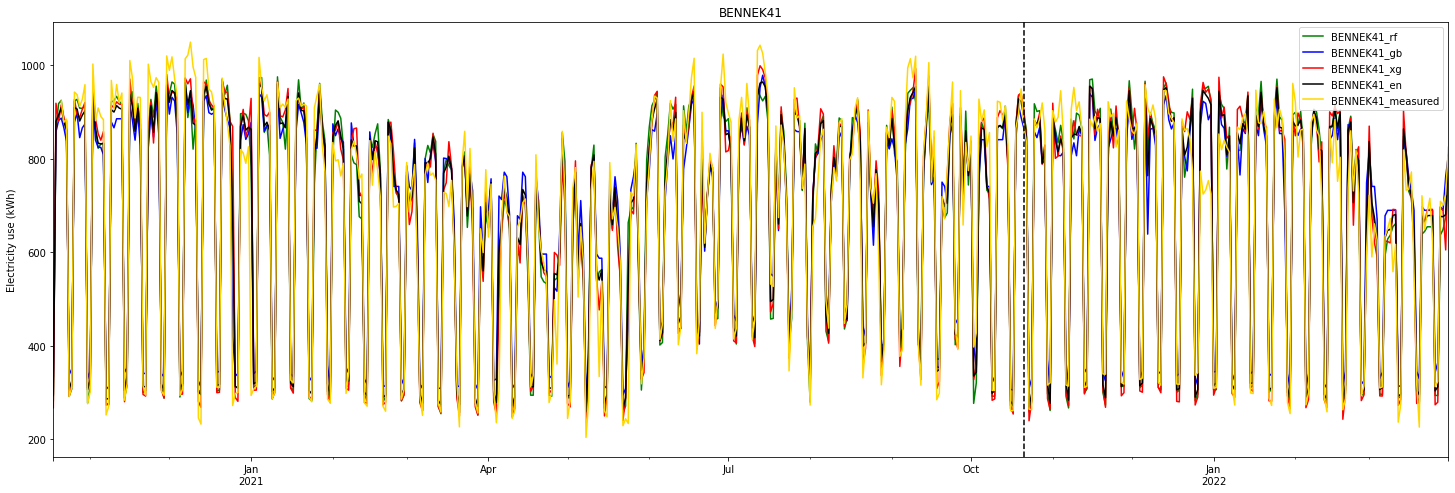

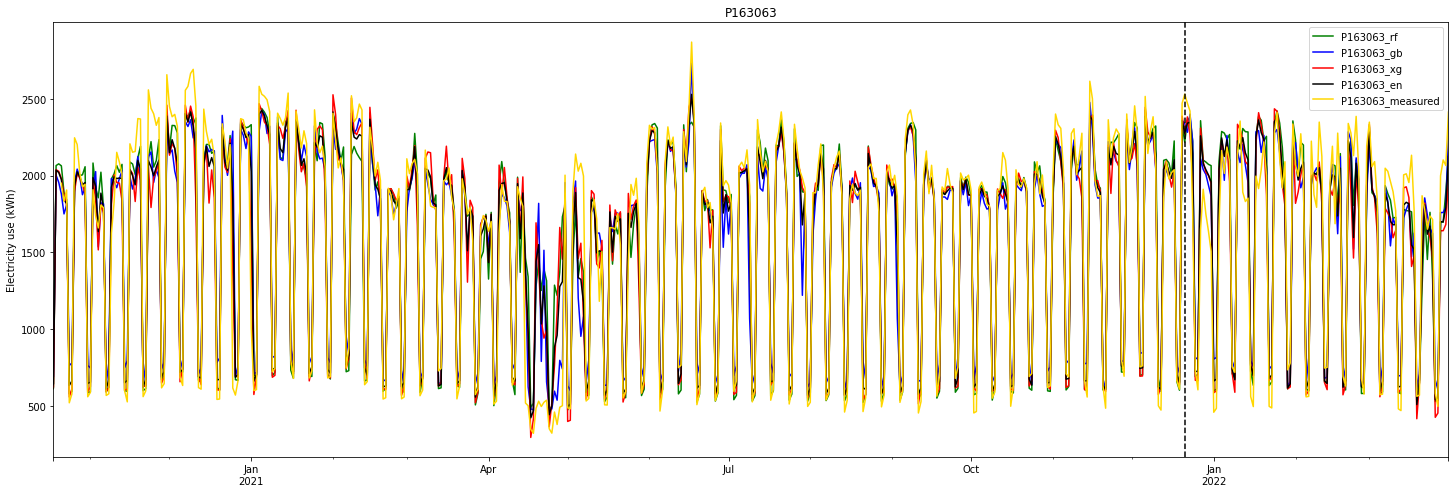

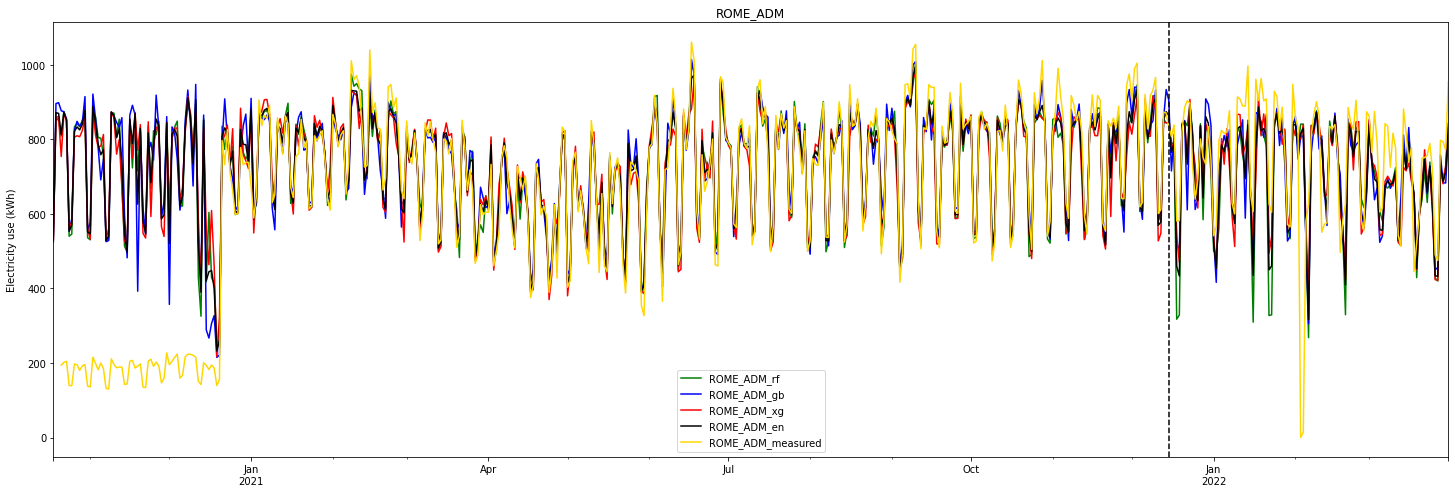

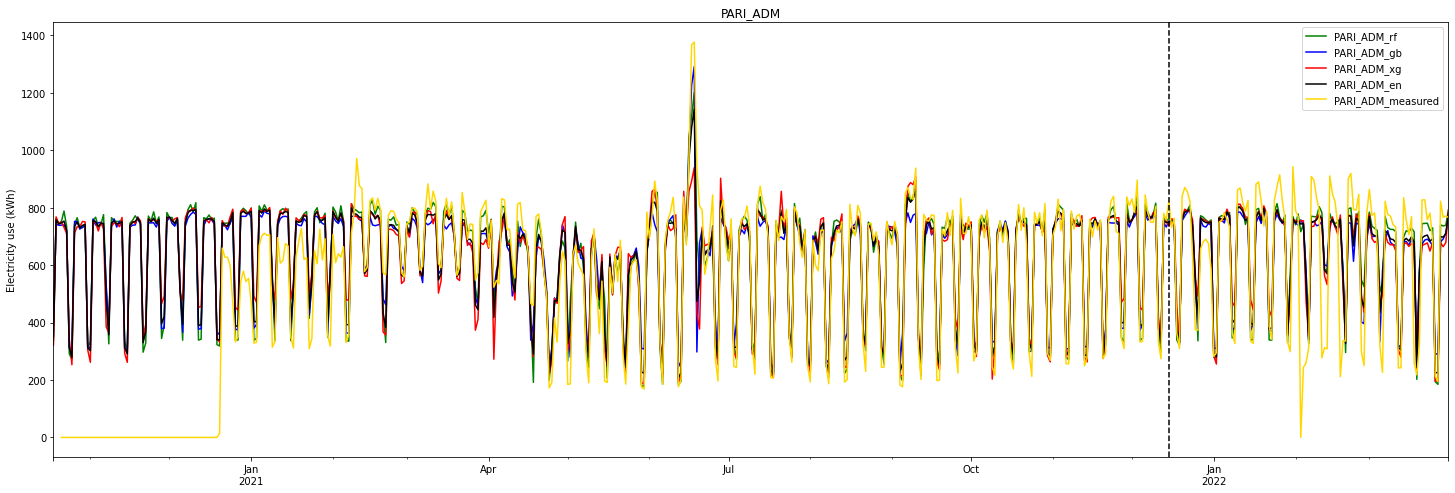

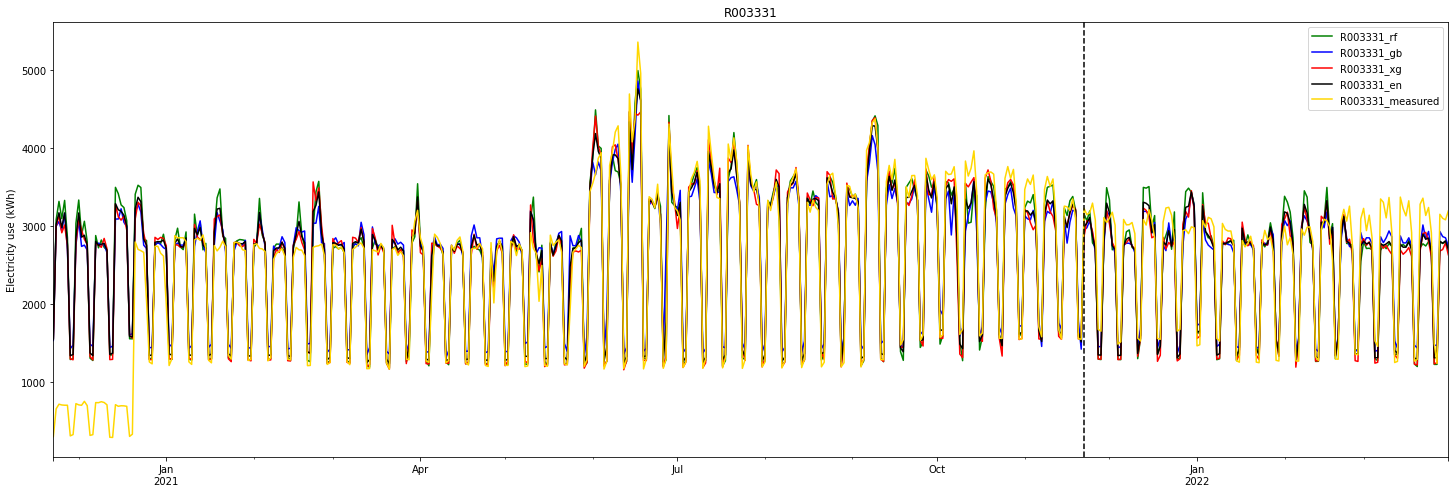

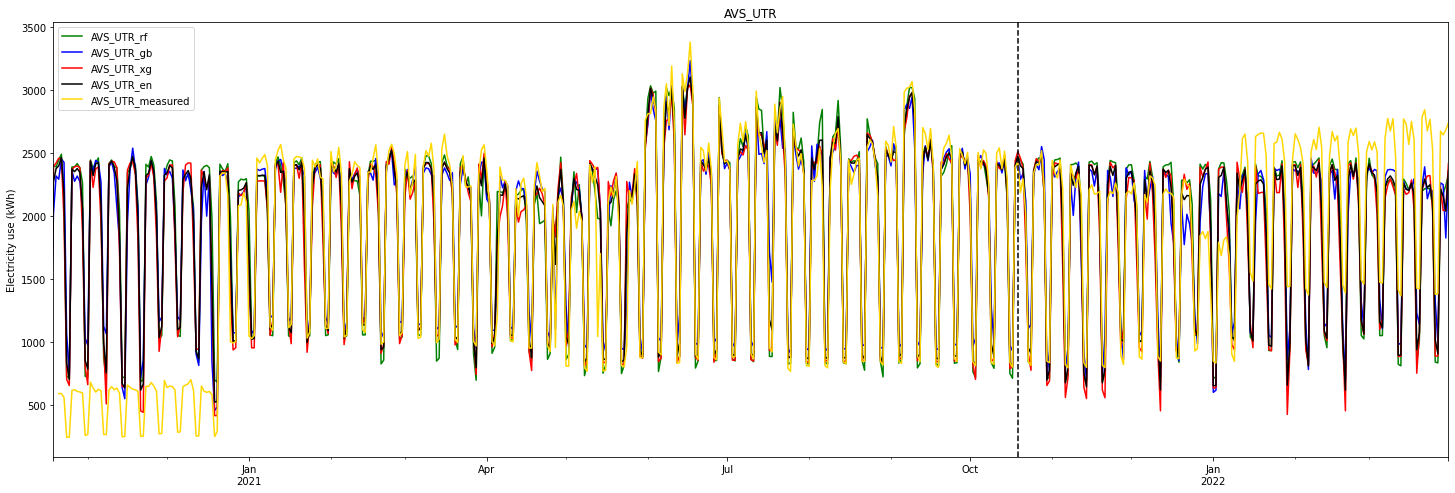

In [891]:
for building in electr_use.columns:
    t=pd.DataFrame()
    fig, ax = plt.subplots(figsize=(25, 8))
    electr_use_pred[building+"_rf"].plot(ax=ax, color='green')
    electr_use_pred[building+"_gb"].plot(ax=ax, color='blue')
    electr_use_pred[building+"_xg"].plot(ax=ax, color='red')
    electr_use_pred[building+"_en"].plot(ax=ax, color='black')
    t[building+"_measured"]=electr_use_meas[building+"_rf"]
    t.plot(ax=ax, color='gold')
    #electr_use_pred_en[building].plot(ax=ax, color='black')
    ax.set_xlim(left=electr_use_train[building].dropna().index[0])
    ax.set_title(building)
    ax.set_ylabel('Electricity use (kWh)')
    ax.legend()
    ax.axvline(x=socs[building], color='k', ls='--')
    plt.show(block=False)

### Comparison of individual models

In [892]:
electr_use_pred = pd.DataFrame(index=features.index)
for building in electr_use.columns:
    # select weather data for prediction
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    # preapare features for prediction
    features = pd.DataFrame()
    features['SQ'] = knmi_weather['SQ'].resample('d').mean()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    X_pred = features
    # do the predictions
    models = os.listdir('NSI_electr/data/trained_models/xg') #Change RF/GB/XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'NSI_electr/data/trained_models/xg/trained_{building}.joblib') #Change RF/GB/XG
    y_pred = grid_search.predict(X_pred)
    electr_use_pred[building] = y_pred

# Results

In [893]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                              end=knmi_weather.index[-1],
                                              freq=time_res))
# pulls data from sp-ql
for building in build_names:
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use_meas = electr_use_meas.join(electr)
        #else:
            #print(fr'{building} - electricity EAN:{electr_eans[building]} not found')
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use_meas = electr_use_meas.join(electr)
            #else:
                #print(fr'{building} - electricity EAN:{ean} not found')

In [894]:
electr_use_meas = electr_use_meas.resample('d').sum()

In [895]:
filter_col = [col for col in electr_use_meas if col.startswith('R003331')]
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0)
electr_use_meas['R003331_ALL']=electr_use_meas[filter_col].sum(axis=1)
electr_use_meas['R003331_ALL']=electr_use_meas['R003331_ALL'].replace({'0':np.nan, 0:np.nan})

In [896]:
filter_col = [col for col in electr_use_meas if col.startswith('AVS_UTR')]
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0)
electr_use_meas['AVS_UTR_ALL']=electr_use_meas[filter_col].sum(axis=1)
electr_use_meas['AVS_UTR_ALL']=electr_use_meas['AVS_UTR_ALL'].replace({'0':np.nan, 0:np.nan})

In [897]:
electr_use_meas=electr_use_meas.drop(['R003331_871687400001086802',
                 'R003331_871687400002056224', 'R003331_871687400002056231', 'R003331_871687400008697070', 'R003331_871687400009144542',
                                           'AVS_UTR_871687400002070169','AVS_UTR_871687400002070138'], axis=1) #drops columns now grouped

In [898]:
electr_use_meas.rename(columns = {'DIEMEN_871685900041463042':'DIEMEN', 'FOKKERWG_871685900000028770':'FOKKERWG', 'BENNEK41_871687120101437013':'BENNEK41', 
                                     'AVS_UTR_871687400002070169':'AVS_UTR', 'P163063_871685900000028947':'P163063', 'P2639_871685900000028947':'P2639',
                                    'ROME_ADM_871685900000033477':'ROME_ADM', 'PARI_ADM_871685900041466814':'PARI_ADM',
                                    'R003331_ALL':'R003331', 'AVS_UTR_ALL':'AVS_UTR'}, inplace = True)

In [907]:
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()
for building in electr_use_meas.columns:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    soc = socs[building]
    electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('m').sum()
    electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('m').sum()
    month_saving = (electr_use_pred_m - electr_use_meas_m) / electr_use_pred_m * 100
    month_savings[building] = month_saving
    month_savings_m3[building] = electr_use_pred_m - electr_use_meas_m
    total_savings_m3[building] = (electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum()
    print(electr_use_pred.loc[soc:, building])
    total_savings_perc[building] = total_savings_m3[building] / electr_use_pred.loc[soc:, building].sum() * 100

train_pred_mae = pd.Series()
for building in electr_use_meas.columns:
    soc = socs[building]
    start = train_periods.loc[building, 'start']
    end = train_periods.loc[building, 'end'] #knmi_weather.index[-1]
    electr_use_meas_m = electr_use_meas.loc[start:end, building].resample('m').sum()
    electr_use_pred_m = electr_use_pred.loc[start:end, building].resample('m').sum()
    electr_use_month_mae = mean_absolute_error(y_true=electr_use_meas_m, y_pred=electr_use_pred_m)
    train_pred_mae[building] = electr_use_month_mae

2021-10-26    1415.546753
2021-10-27    1265.000366
2021-10-28    1229.455200
2021-10-29    1266.678955
2021-10-30     763.972595
                 ...     
2022-03-27     549.997620
2022-03-28    1163.024170
2022-03-29    1230.129028
2022-03-30    1345.138062
2022-03-31    1342.912476
Freq: D, Name: DIEMEN, Length: 157, dtype: float32
2021-10-18    873.898865
2021-10-19    969.048096
2021-10-20    957.780762
2021-10-21    853.906494
2021-10-22    837.322205
                 ...    
2022-03-27    203.417267
2022-03-28    784.203064
2022-03-29    781.413269
2022-03-30    776.565186
2022-03-31    878.448853
Freq: D, Name: FOKKERWG, Length: 165, dtype: float32
2021-10-21    906.152161
2021-10-22    848.334106
2021-10-23    239.410934
2021-10-24    280.807220
2021-10-25    871.727661
                 ...    
2022-03-27    279.149414
2022-03-28    696.134705
2022-03-29    689.851807
2022-03-30    605.052673
2022-03-31    798.471558
Freq: D, Name: BENNEK41, Length: 162, dtype: float32
2021-12

In [911]:
total_savings_m3.sum().sum()

-108318.74520970637

In [914]:
for building in electr_use_meas.columns:
    total_savings_m3[building] = (electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = ((electr_use_pred.loc[soc:, building] - electr_use_meas.loc[soc:, building]).sum() / electr_use_pred.loc[soc:, building].sum()) * 100
total_savings_perc

DIEMEN     -10.283683
FOKKERWG   -23.427790
BENNEK41     1.163538
P163063     -2.997144
ROME_ADM    -5.356471
PARI_ADM     2.289344
R003331     -5.531434
AVS_UTR    -10.358356
dtype: float64

### Bar plot analysis

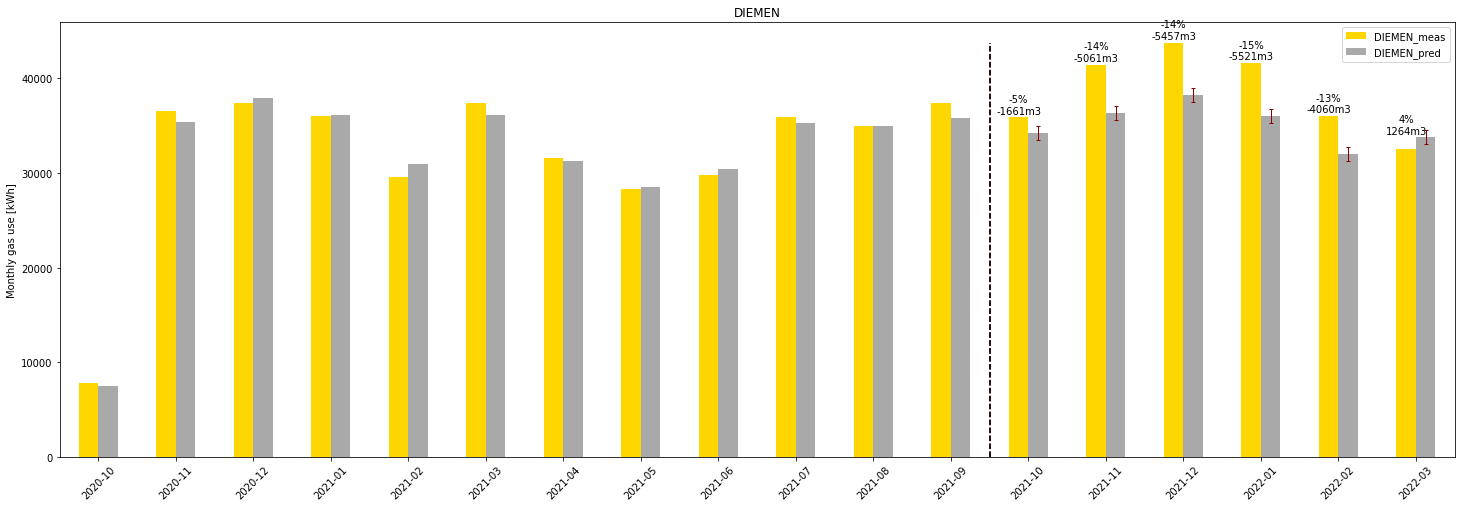

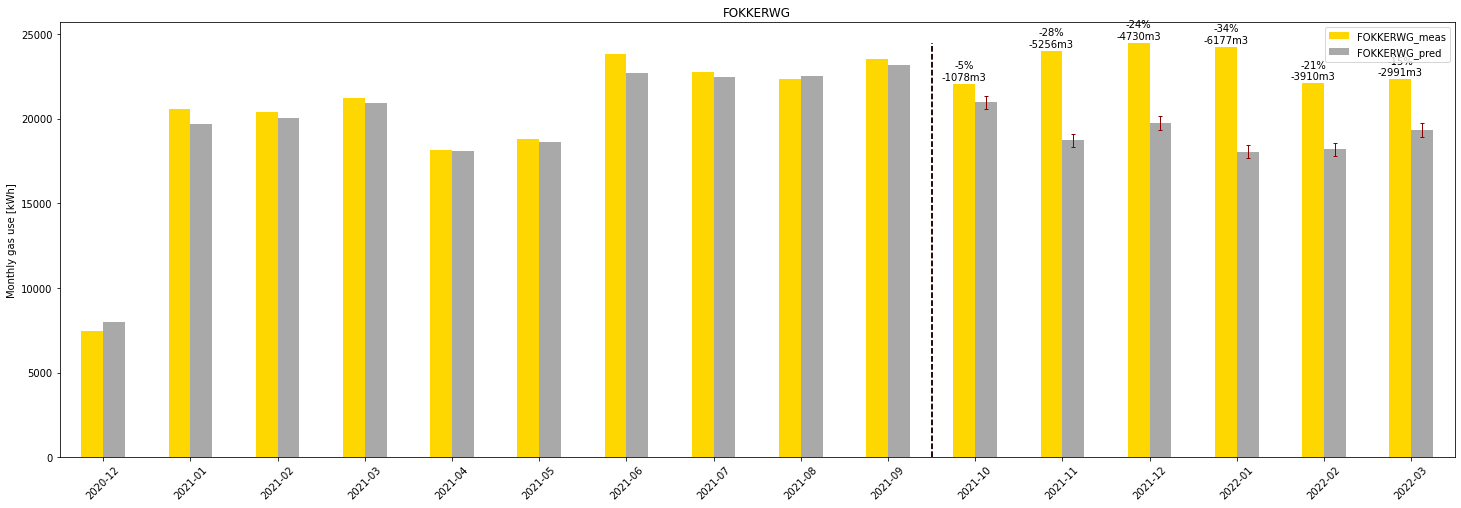

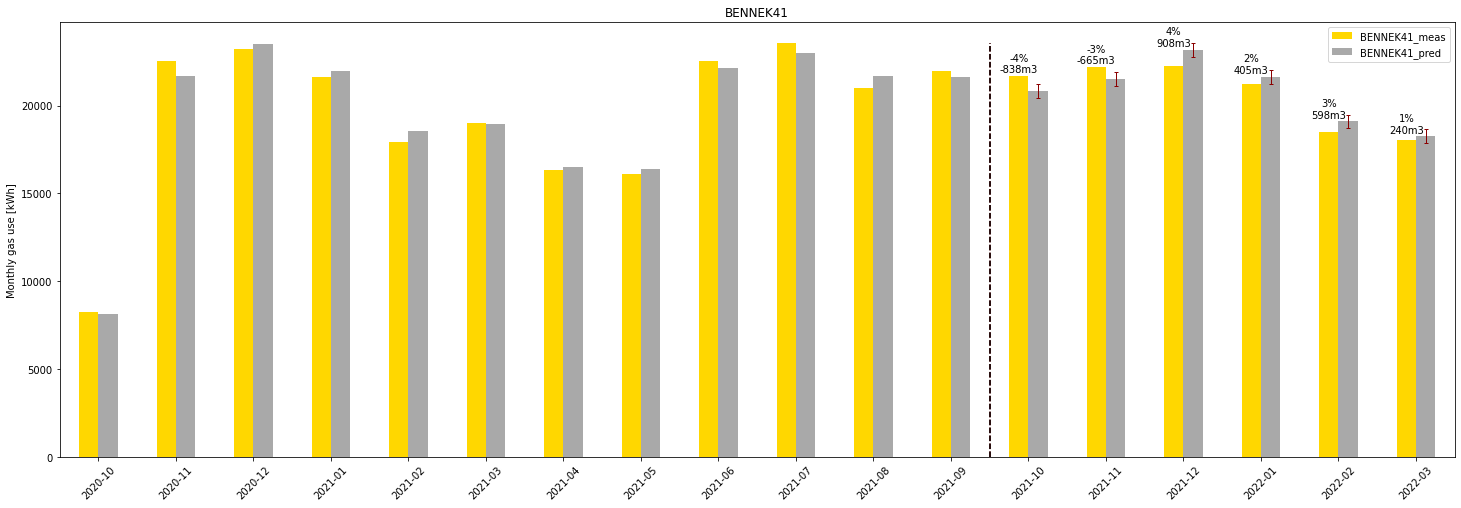

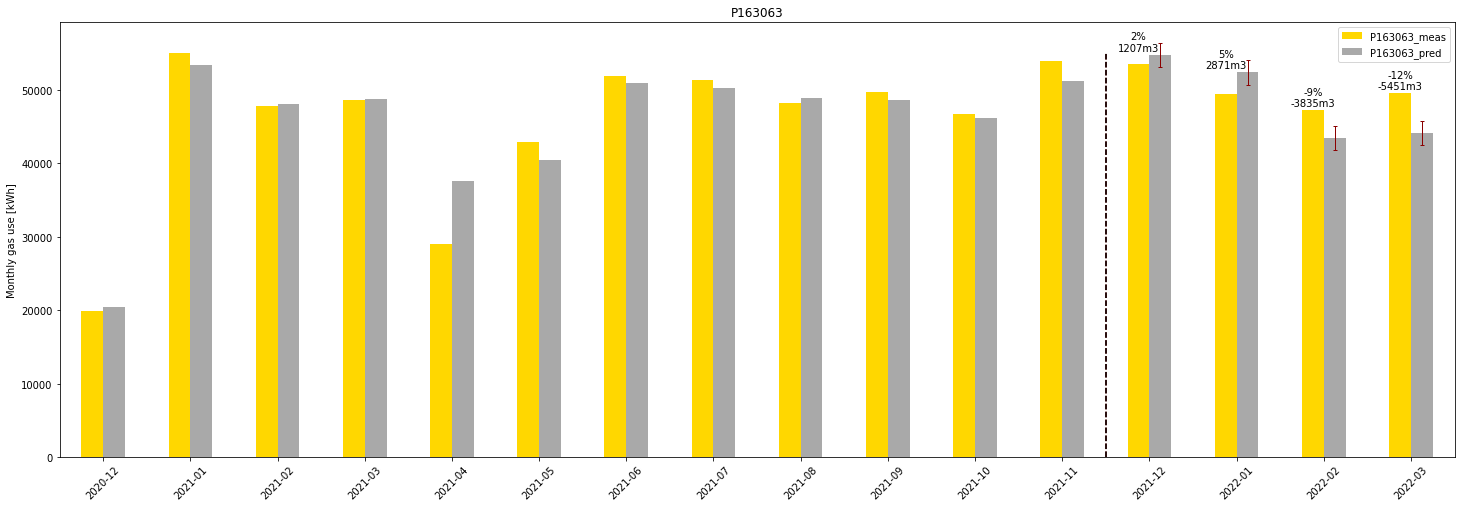

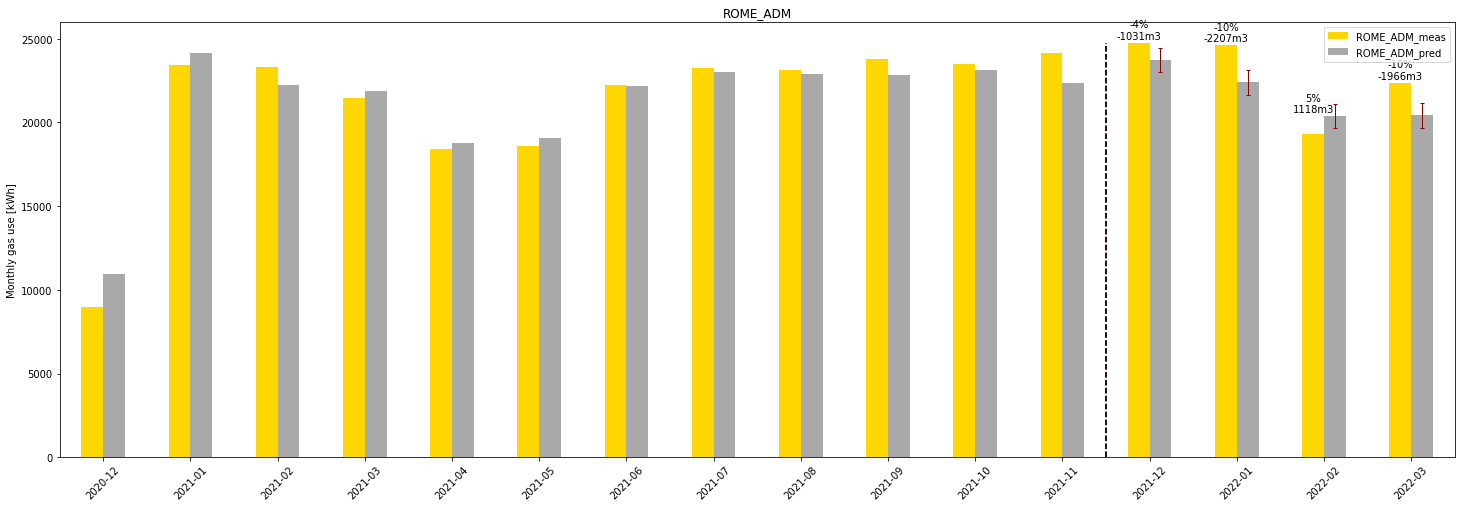

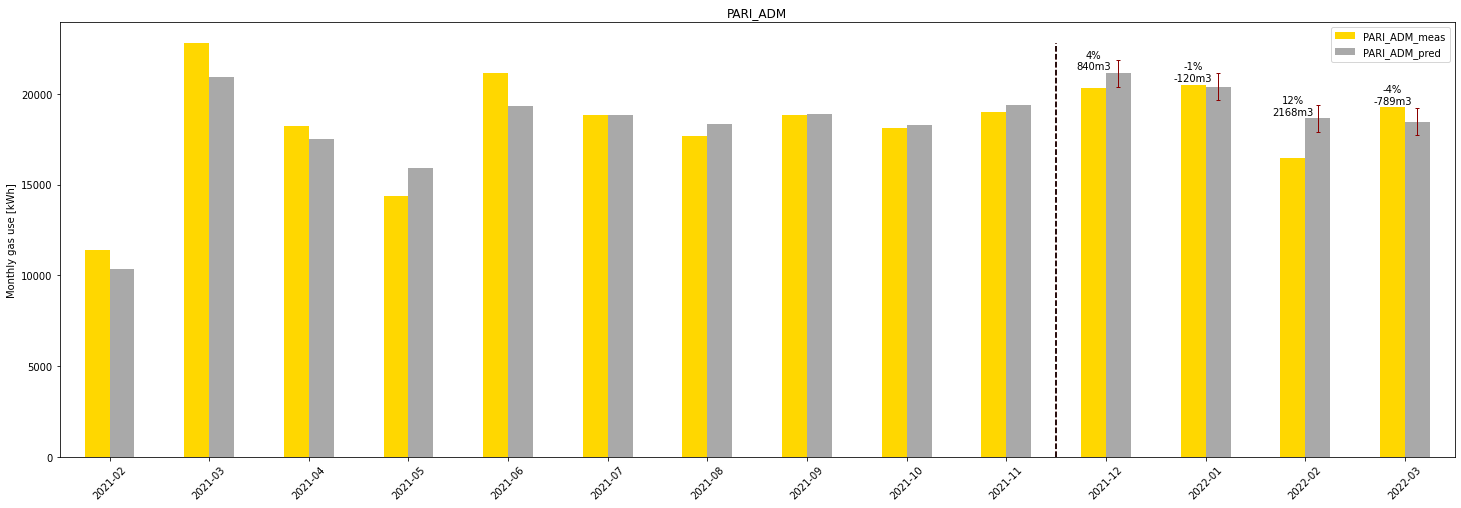

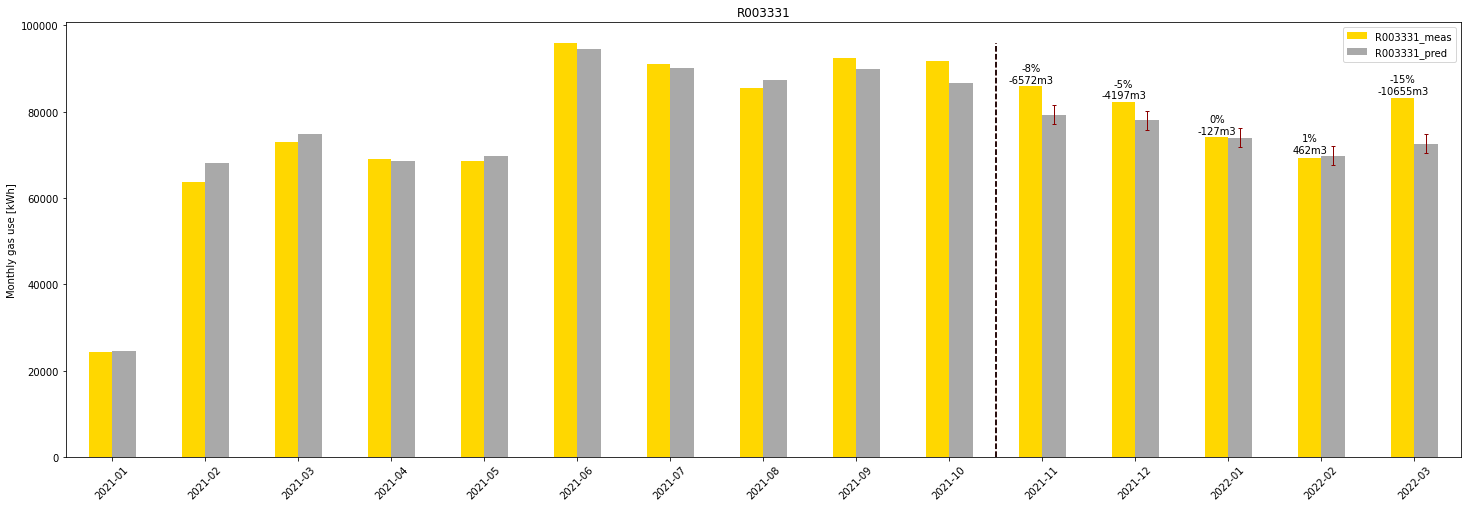

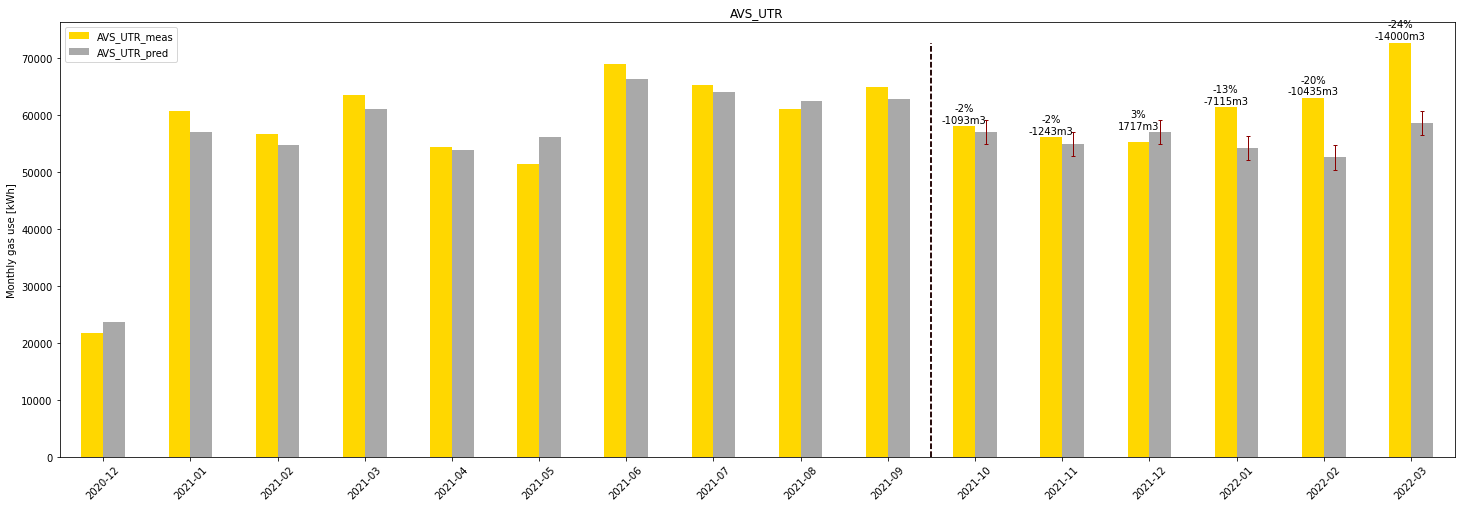

In [915]:
for building in electr_use.columns:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(electr_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(electr_use_pred[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pred'})
    #
    df_compare = df_compare.resample('m').sum()
    soc = socs[building]#.date()
    soc_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=soc)
    train_end_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=train_periods.loc[building, 'end'])
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    err = pd.DataFrame(index=df_compare.index, data={fr'{building}_pred':train_pred_mae[building]})
    err.iloc[:int(soc_pos) + 1] = np.nan
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgray'], yerr=err,
                        error_kw=dict(ecolor='darkred', lw=1, capsize=2, capthick=1))
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]
    for i, p in enumerate(patches[0:int(len(patches)/2)]):
        if i > soc_pos:
            saving = int(month_savings[building].iloc[i].round(0))
            saving_m3 = int(month_savings_m3[building].iloc[i].round(0))
            width = p.get_width()
            height = max(p.get_height(), patches_p[i].get_height())
            x, y = p.get_xy()
            ax.annotate(f'{saving}%\n{saving_m3}m3', (x + width/2, y + height*1.01), ha='center')
    #
    plt.ylabel('Monthly gas use [kWh]')
    plt.title(building)
    plt.show(block=False)

In [939]:
# calculate monthly portfolio savings
electr_use_pred_sav = electr_use_pred
electr_use_meas_sav = electr_use_meas
for building in electr_use.columns:
    electr_use_pred_sav.loc[electr_use_pred_sav.index[0]:socs[building], building] = np.nan
    electr_use_meas_sav.loc[electr_use_meas_sav.index[0]:socs[building], building] = np.nan
electr_use_sav = electr_use_pred_sav - electr_use_meas_sav
electr_use_sav = electr_use_sav.resample('m').sum()
electr_use_sav = electr_use_sav.loc[socs[electr_eans.index].min():]

In [940]:
for building in electr_use_sav.columns:
    print(building, "total savings since SOC (kWh):", round(electr_use_sav[building].sum(),2))

DIEMEN total savings since SOC (kWh): -19143.47
FOKKERWG total savings since SOC (kWh): -24100.12
BENNEK41 total savings since SOC (kWh): 1246.37
P163063 total savings since SOC (kWh): -4523.81
ROME_ADM total savings since SOC (kWh): -3346.47
PARI_ADM total savings since SOC (kWh): 2062.09
R003331 total savings since SOC (kWh): -16282.55
AVS_UTR total savings since SOC (kWh): -31283.48


In [941]:
electr_use_sav

,DIEMEN,FOKKERWG,BENNEK41,P163063,ROME_ADM,PARI_ADM,R003331,AVS_UTR
2021-10-31,-307.426542,-1036.945727,-238.261176,0.000000,0.000000,0.000000,0.000000,-206.623007
2021-11-30,-5061.484534,-5255.615530,-665.346330,0.000000,0.000000,0.000000,-1765.698431,-1243.267344
2021-12-31,-5457.091669,-4730.154162,907.666391,1891.262346,-291.948489,801.899423,-4196.583564,1717.050866
2022-01-31,-5521.065803,-6176.500618,404.594433,2871.092081,-2206.633539,-119.552260,-127.392267,-7114.975559
2022-02-28,-4060.191064,-3909.832497,597.823455,-3835.287258,1118.096003,2168.341509,461.848715,-10435.189895
2022-03-31,1263.791347,-2991.068280,239.890069,-5450.876822,-1965.981000,-788.594765,-10654.728923,-14000.472452


In [942]:
round(electr_use_sav.sum().sum(),2)

-95371.43

In [943]:
round(electr_use_sav.sum().sum()*0.23,2)

-21935.43

### Monthly portfolio savings

In [934]:
electr_use_pred_sav = electr_use_pred
electr_use_meas_sav = electr_use_meas
for building in electr_use.columns:
    electr_use_pred_sav.loc[electr_use_pred_sav.index[0]:socs[building], building] = np.nan
    electr_use_meas_sav.loc[electr_use_meas_sav.index[0]:socs[building], building] = np.nan
electr_use_sav = electr_use_pred_sav - electr_use_meas_sav
electr_use_sav = electr_use_sav.resample('m').sum()
electr_use_sav = electr_use_sav.loc[socs[electr_use.columns].min():]
electr_use_sav['m3_cost']=0.23 #assuming cost of kWh is 0.23 cents, could be changed
for col in electr_use_sav.columns:
    electr_use_sav[col]=round(electr_use_sav['m3_cost']*electr_use_sav[col],2)
del electr_use_sav['m3_cost']
electr_use_sav

,DIEMEN,FOKKERWG,BENNEK41,P163063,ROME_ADM,PARI_ADM,R003331,AVS_UTR
2021-10-31,-70.71,-238.50,-54.80,0.00,0.00,0.00,0.00,-47.52
2021-11-30,-1164.14,-1208.79,-153.03,0.00,0.00,0.00,-406.11,-285.95
2021-12-31,-1255.13,-1087.94,208.76,434.99,-67.15,184.44,-965.21,394.92
2022-01-31,-1269.85,-1420.60,93.06,660.35,-507.53,-27.50,-29.30,-1636.44
2022-02-28,-933.84,-899.26,137.50,-882.12,257.16,498.72,106.23,-2400.09
2022-03-31,290.67,-687.95,55.17,-1253.70,-452.18,-181.38,-2450.59,-3220.11


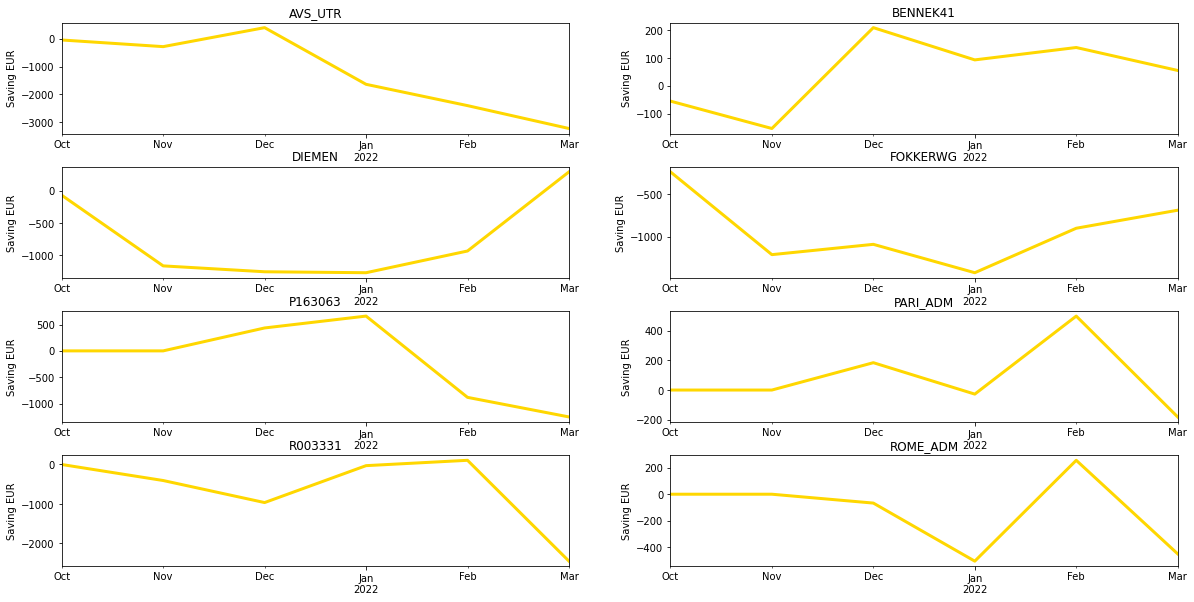

In [935]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)
for col, ax in zip(sorted(electr_use_sav.columns), axs.ravel()):
    electr_use_sav[[col]].iloc[0:6].plot(ax=ax, color='gold', linewidth=3) #excludes April for now, too early in the month to draw results
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_ylabel("Saving EUR")

# Forecasting

In [626]:
#forecast periods are defined, which is - per building - SOC up until 31st of March 2022
forecast_periods=pd.DataFrame()
forecast_periods['start'] = socs[electr_use.columns]
forecast_periods['end'] = pd.Timestamp('2022-03-31')
forecast_periods=forecast_periods[~forecast_periods.index.duplicated(keep='first')]
forecast_periods

,start,end
DIEMEN,2021-10-26,2022-03-31
FOKKERWG,2021-10-18,2022-03-31
BENNEK41,2021-10-21,2022-03-31
P163063,2021-12-21,2022-03-31
ROME_ADM,2021-12-15,2022-03-31
PARI_ADM,2021-12-15,2022-03-31
R003331,2021-11-22,2022-03-31
AVS_UTR,2021-10-19,2022-03-31


In [627]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h' # daily
electr_use = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                              end=forecast_periods['end'].max(),
                                              freq=time_res))

# pulls data from sp-ql
for building in build_names:
    start = forecast_periods.loc[building, 'start']
    end = forecast_periods.loc[building, 'end']
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use = electr_use.join(electr)
        else:
            print(fr'{building} - electricity EAN:{electr_eans[building]} not found')
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use = electr_use.join(electr)
            else:
                print(fr'{building} - electricity EAN:{ean} not found')
                
                
electr_use = electr_use.resample('d').sum() #sums the kWh to daily readings
filter_col = [col for col in electr_use if col.startswith('R003331')]
electr_use[filter_col]=electr_use[filter_col].fillna(0)
electr_use['R003331_ALL']=electr_use[filter_col].sum(axis=1)
electr_use['R003331_ALL']=electr_use['R003331_ALL'].replace({'0':np.nan, 0:np.nan})
filter_col = [col for col in electr_use if col.startswith('AVS_UTR')]
electr_use[filter_col]=electr_use[filter_col].fillna(0)
electr_use['AVS_UTR_ALL']=electr_use[filter_col].sum(axis=1)
electr_use['AVS_UTR_ALL']=electr_use['AVS_UTR_ALL'].replace({'0':np.nan, 0:np.nan})
electr_use=electr_use.drop(['R003331_871687400001086802',
                 'R003331_871687400002056224', 'R003331_871687400002056231', 'R003331_871687400008697070', 'R003331_871687400009144542',
                                           'AVS_UTR_871687400002070169','AVS_UTR_871687400002070138'], axis=1) #drops columns now grouped
electr_use.rename(columns = {'DIEMEN_871685900041463042':'DIEMEN', 'FOKKERWG_871685900000028770':'FOKKERWG', 'BENNEK41_871687120101437013':'BENNEK41', 
                                     'AVS_UTR_871687400002070169':'AVS_UTR', 'P163063_871685900000028947':'P163063', 'P2639_871685900000028947':'P2639',
                                    'ROME_ADM_871685900000033477':'ROME_ADM', 'PARI_ADM_871685900041466814':'PARI_ADM',
                                    'R003331_ALL':'R003331', 'AVS_UTR_ALL':'AVS_UTR'}, inplace = True)

### Random Forest

In [628]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    
    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

    features['dow'] = features.index.dayofweek
    
    electr_use_train_build = electr_use[building]
    
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False) # cv --> Kfold 10 with shuffle - because my data is in order (if I would randomize the order then this would not be necessary)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'NSI_electr/data/trained_models/f_rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_electr/data/trained_models/f_rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_electr/data/trained_models/f_rf/y_test_{building}.joblib')

Training building DIEMEN, 1/8
Training building FOKKERWG, 2/8
Training building BENNEK41, 3/8
Training building P163063, 4/8
Training building ROME_ADM, 5/8
Training building PARI_ADM, 6/8
Training building R003331, 7/8
Training building AVS_UTR, 8/8


### Gradient Boosting

In [629]:
##gradient boosting - each building is trained
warnings.filterwarnings("ignore")
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

    features['dow'] = features.index.dayofweek
    
    electr_use_train_build = electr_use[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]

    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }

    rf = GradientBoostingRegressor()

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                        cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'NSI_electr/data/trained_models/f_gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_electr/data/trained_models/f_gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_electr/data/trained_models/f_gb/y_test_{building}.joblib')

Training building DIEMEN, 1/8
Training building FOKKERWG, 2/8
Training building BENNEK41, 3/8
Training building P163063, 4/8
Training building ROME_ADM, 5/8
Training building PARI_ADM, 6/8
Training building R003331, 7/8
Training building AVS_UTR, 8/8


### XGBoosting

In [630]:
for building in electr_use.columns:
    print(fr'Training building {building}, {electr_use.columns.get_loc(building) + 1}/{len(electr_use.columns)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

    features['dow'] = features.index.dayofweek
    
    electr_use_train_build = electr_use[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = electr_use_train_build[(electr_use_train_build.index >= start_train) &
                            (electr_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'NSI_electr/data/trained_models/f_xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'NSI_electr/data/trained_models/f_xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'NSI_electr/data/trained_models/f_xg/y_test_{building}.joblib')

Training building DIEMEN, 1/8
Training building FOKKERWG, 2/8
Training building BENNEK41, 3/8
Training building P163063, 4/8
Training building ROME_ADM, 5/8
Training building PARI_ADM, 6/8
Training building R003331, 7/8
Training building AVS_UTR, 8/8


### Predictions

In [631]:
electr_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in electr_use.columns:
        # select weather data for prediction

        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]

        # preapare features for prediction

        if knmi_station==240:
            features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
        if knmi_station==344:
            features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
        if knmi_station==370:
            features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
        if knmi_station==260:
            features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
        if knmi_station==275:
            features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

        features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

        features['dow'] = features.index.dayofweek

        electr_use_train_build = electr_use[building]
        X_pred = features #using KNMI weather data 2011-2022/04 and the trained model, predictions are made on energy consumption
        models = os.listdir(f'NSI_electr/data/trained_models/f_{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/f_{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        electr_use_pred[building+'_'+m] = y_pred #gives energy consumption for model for building 2011-2022
        #print(electr_use_pred)

In [633]:
#ensemble stacking, equal weight
electr_use_pred['DIEMEN_en']=(electr_use_pred['DIEMEN_rf']+electr_use_pred['DIEMEN_gb']+electr_use_pred['DIEMEN_xg'])/3
electr_use_pred['FOKKERWG_en']=(electr_use_pred['FOKKERWG_rf']+electr_use_pred['FOKKERWG_gb']+electr_use_pred['FOKKERWG_xg'])/3
electr_use_pred['BENNEK41_en']=(electr_use_pred['BENNEK41_rf']+electr_use_pred['BENNEK41_gb']+electr_use_pred['BENNEK41_xg'])/3
electr_use_pred['P163063_en']=(electr_use_pred['P163063_rf']+electr_use_pred['P163063_gb']+electr_use_pred['P163063_xg'])/3
electr_use_pred['ROME_ADM_en']=(electr_use_pred['ROME_ADM_rf']+electr_use_pred['ROME_ADM_gb']+electr_use_pred['ROME_ADM_xg'])/3
electr_use_pred['PARI_ADM_en']=(electr_use_pred['PARI_ADM_rf']+electr_use_pred['PARI_ADM_gb']+electr_use_pred['PARI_ADM_xg'])/3
electr_use_pred['R003331_en']=(electr_use_pred['R003331_rf']+electr_use_pred['R003331_gb']+electr_use_pred['R003331_xg'])/3
electr_use_pred['AVS_UTR_en']=(electr_use_pred['AVS_UTR_rf']+electr_use_pred['AVS_UTR_gb']+electr_use_pred['AVS_UTR_xg'])/3

### Actual

In [634]:
## get electr use data
engine = Engine(project=project, isAsync=False)
time_res = 'h'
electr_use_meas = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                              end=knmi_weather.index[-49]+dt.timedelta(30),
                                              freq=time_res))
# pulls data from sp-ql
for building in build_names:
    start = forecast_periods['start'].min()
    end = knmi_weather.index[-1]+dt.timedelta(28)
    electr_ean = electr_eans[building]
    if isinstance(electr_ean, str):
        electr = engine.select(electr_ean).group_by(time_res).mean().after(start).before(end).all() #the result is now kW power in hourly resolution, which is numerically identical to the hourly kWh value
        if len(electr) > 0:
            electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
            electr_use_meas = electr_use_meas.join(electr)
    else:
        for ean in electr_ean:
            electr = engine.select(ean).group_by(time_res).mean().after(start).before(end).all()
            if len(electr) > 0:
                electr = electr.rename(columns={electr.columns[0]:fr'{building}_{electr.columns[0]}'})
                electr_use_meas = electr_use_meas.join(electr)
electr_use_meas = electr_use_meas.resample('d').sum()
filter_col = [col for col in electr_use_meas if col.startswith('R003331')]
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0)
electr_use_meas['R003331_ALL']=electr_use_meas[filter_col].sum(axis=1)
electr_use_meas['R003331_ALL']=electr_use_meas['R003331_ALL'].replace({'0':np.nan, 0:np.nan})
filter_col = [col for col in electr_use_meas if col.startswith('AVS_UTR')]
electr_use_meas[filter_col]=electr_use_meas[filter_col].fillna(0)
electr_use_meas['AVS_UTR_ALL']=electr_use_meas[filter_col].sum(axis=1)
electr_use_meas['AVS_UTR_ALL']=electr_use_meas['AVS_UTR_ALL'].replace({'0':np.nan, 0:np.nan})
electr_use_meas=electr_use_meas.drop(['R003331_871687400001086802',
                 'R003331_871687400002056224', 'R003331_871687400002056231', 'R003331_871687400008697070', 'R003331_871687400009144542',
                                           'AVS_UTR_871687400002070169','AVS_UTR_871687400002070138'], axis=1) #drops columns now grouped
electr_use_meas.rename(columns = {'DIEMEN_871685900041463042':'DIEMEN', 'FOKKERWG_871685900000028770':'FOKKERWG', 'BENNEK41_871687120101437013':'BENNEK41', 
                                     'AVS_UTR_871687400002070169':'AVS_UTR', 'P163063_871685900000028947':'P163063', 'P2639_871685900000028947':'P2639',
                                    'ROME_ADM_871685900000033477':'ROME_ADM', 'PARI_ADM_871685900041466814':'PARI_ADM',
                                    'R003331_ALL':'R003331', 'AVS_UTR_ALL':'AVS_UTR'}, inplace = True)

In [635]:
def calc_date_pos_on_plot(df_compare_monthly):
    soc=pd.Timestamp('2022-04-01 00:00:00')
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

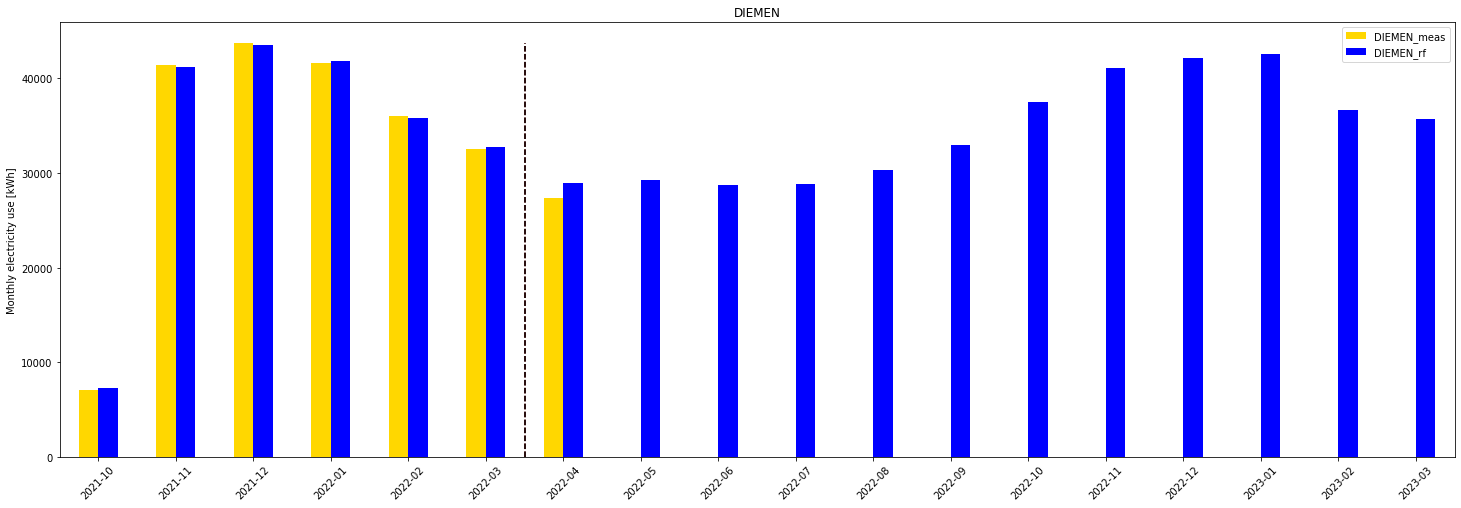

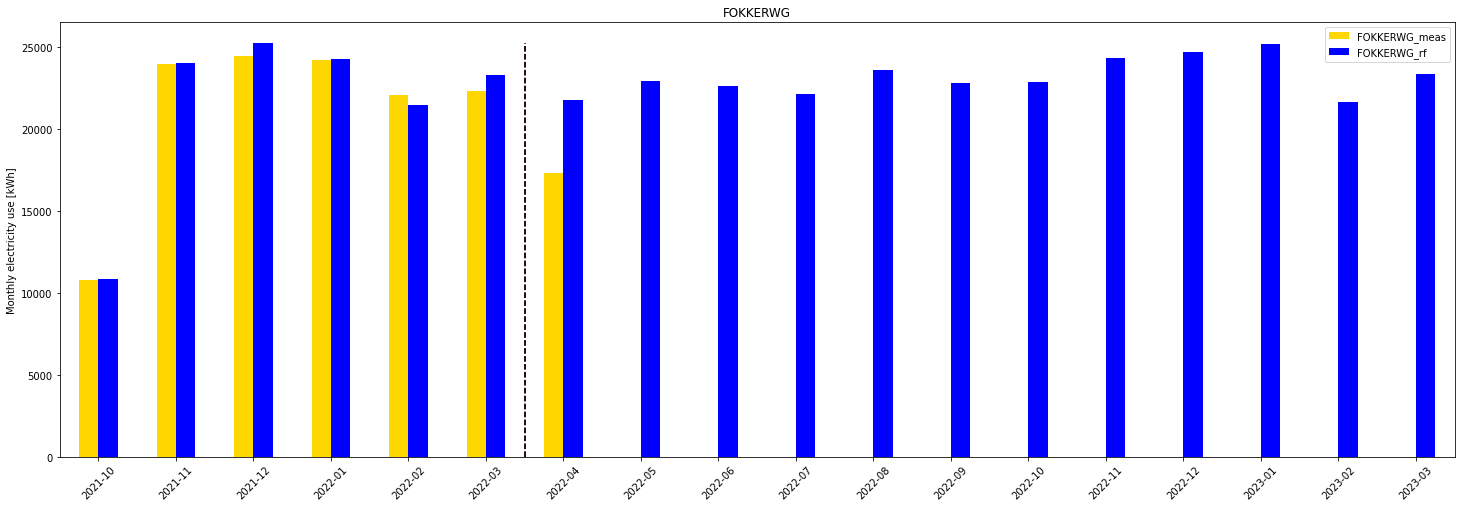

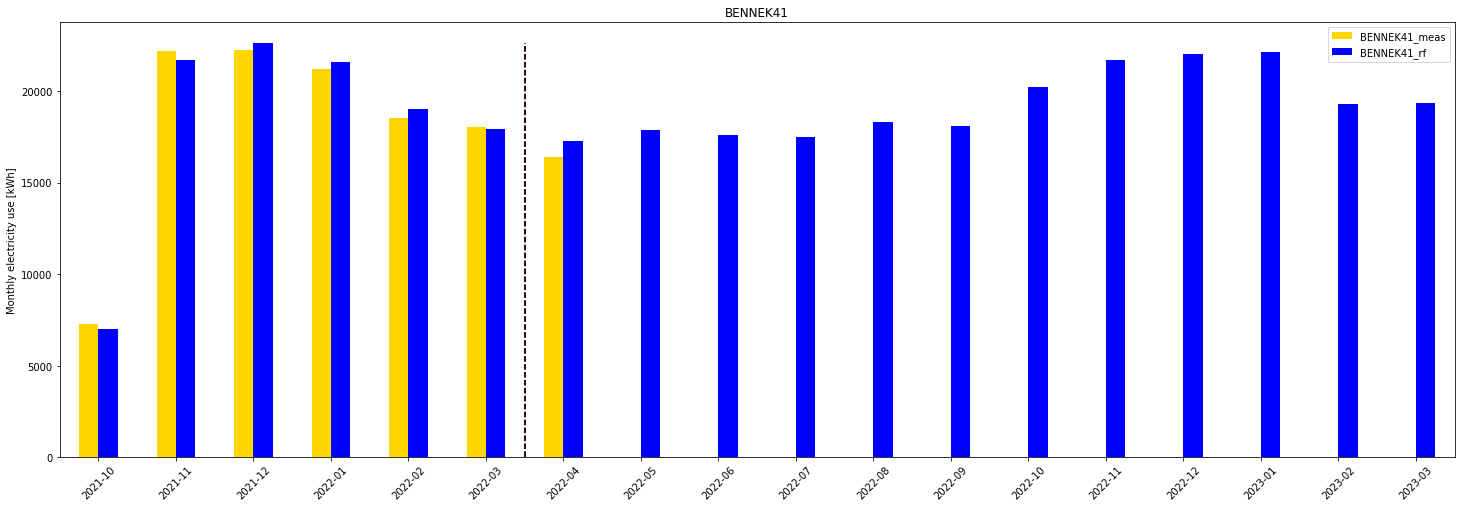

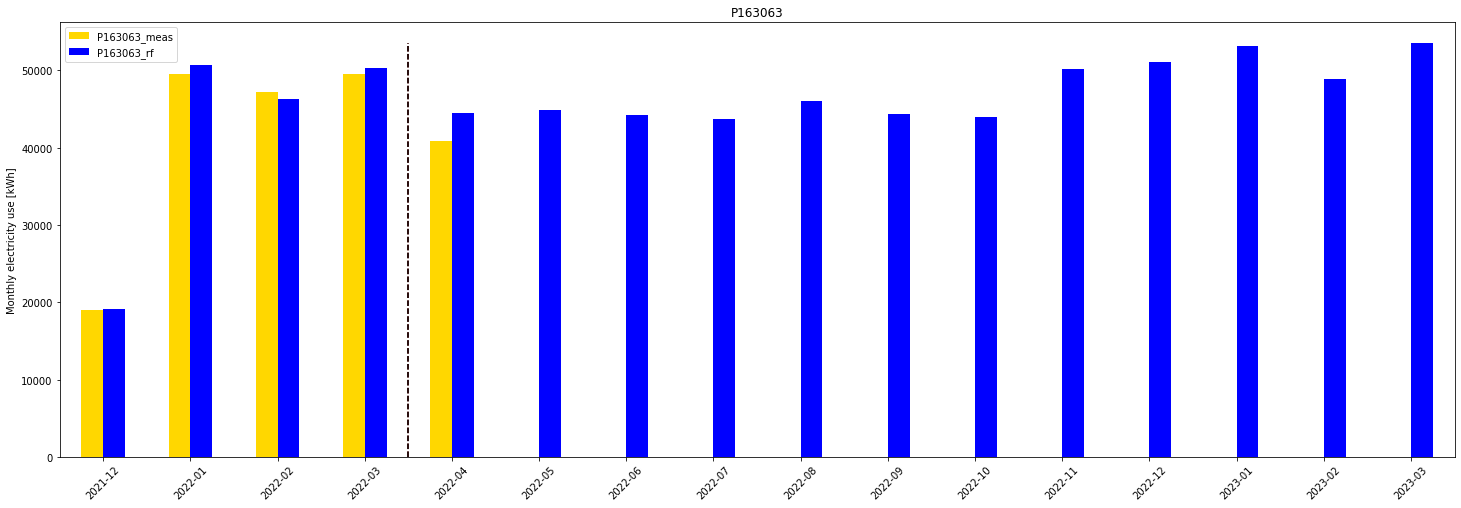

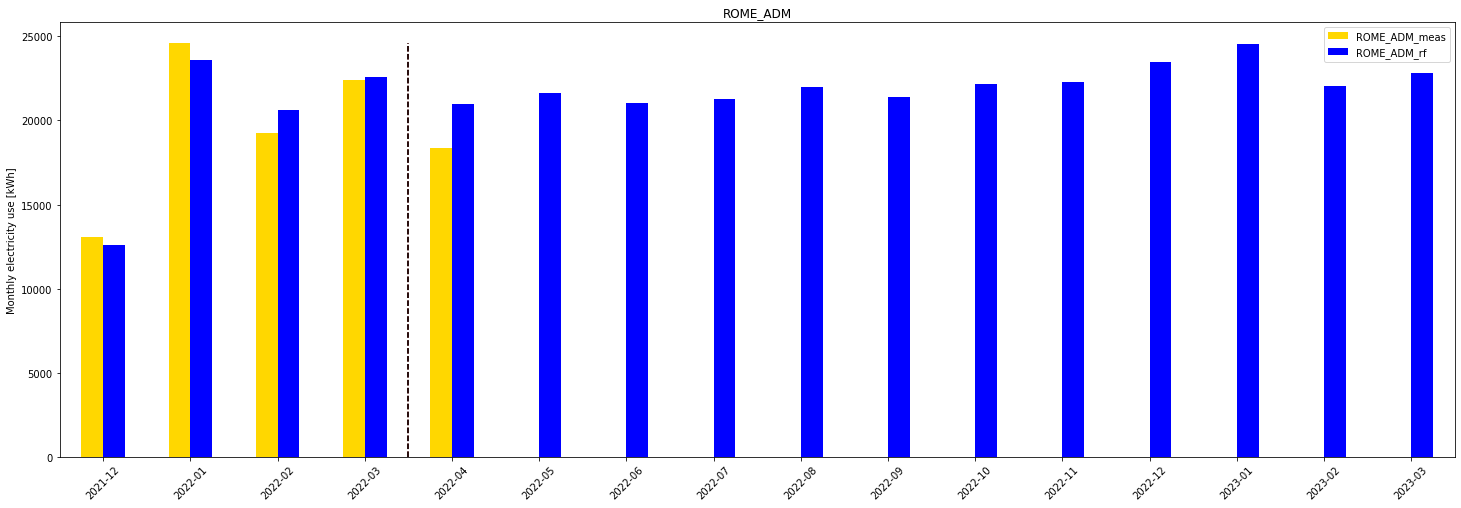

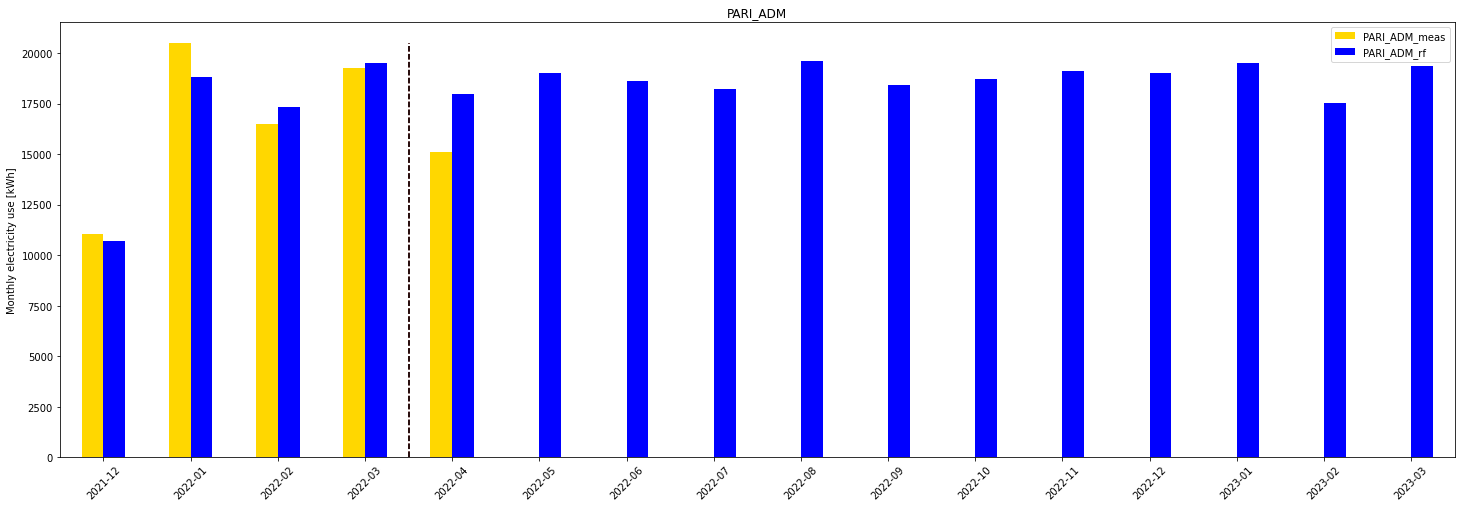

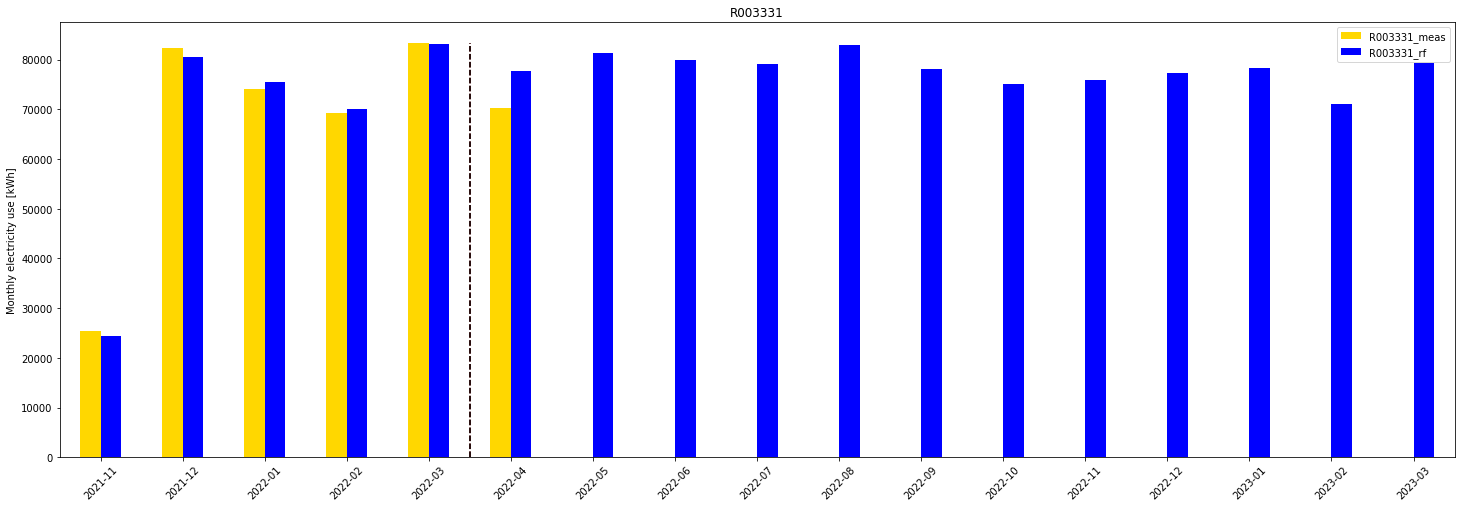

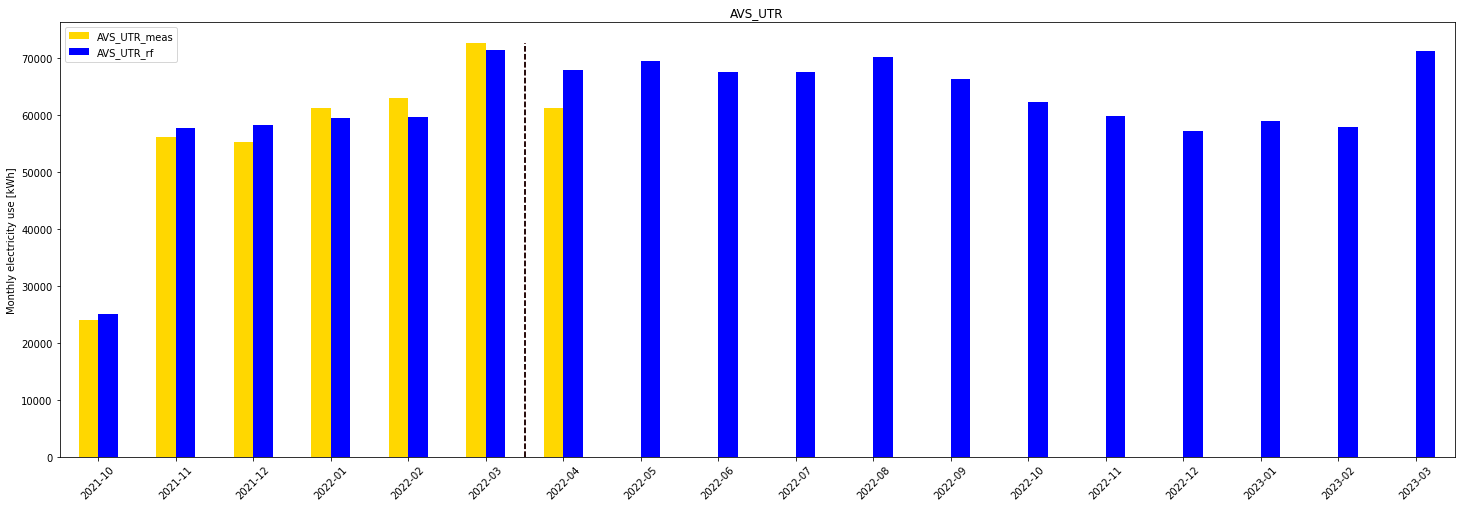

In [644]:
for building in electr_use.columns:
    start = forecast_periods.loc[building, 'start']
    end = electr_use_pred.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(electr_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(electr_use_pred[[building+"_rf"]])
    #df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    #df_compare = df_compare.join(electr_use_pred[[building+"_gb"]])
    #df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    #df_compare = df_compare.join(electr_use_pred[[building+"_xg"]])
    #df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    #
    df_compare = df_compare.resample('m').sum()

    soc = socs[building]#.date()
    soc_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    train_end_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    df_compare.plot.bar(ax=ax, color=['gold', 'blue', 'red', 'green'])
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]

    plt.ylabel('Monthly electricity use [kWh]')
    plt.title(building)
    plt.show(block=False)

In [637]:
metric_com_mae = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'NSI_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        electr_use_train_build = electr_use[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

In [638]:
metric_com_rmse = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in electr_use.columns:
        models = os.listdir(f'NSI_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

In [639]:
en_mae = pd.DataFrame(index=electr_use.columns)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'NSI_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]
    

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent

### MAEs

In [640]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                RF         GB        XG        EN
DIEMEN    3.652508   6.798193  2.683633  2.630482
FOKKERWG  4.847402   5.978184  5.940630  3.369978
BENNEK41  3.940534   6.979071  4.129129  3.315881
P163063   5.398208   8.851251  4.012386  3.335943
ROME_ADM  5.383320   8.616312  7.552799  4.592197
PARI_ADM  6.066539  12.443026  7.780834  6.651371
R003331   3.315607   4.853172  3.177797  2.776740
AVS_UTR   4.977444   8.685554  7.111875  4.277890


Average MAEs


RF    4.69770
GB    7.90060
XG    5.29864
EN    3.86881
dtype: float64

In [641]:
en_rmse = pd.DataFrame(index=electr_use.columns) #verander naam van variabele
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in electr_use.columns:
    for regressor in regressors:
        models = os.listdir(f'NSI_electr/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'NSI_electr/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent

### RMSEs

In [642]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                RF         GB         XG        EN
DIEMEN    4.995092   8.598003   3.476888  3.524729
FOKKERWG  7.292335   7.729842   8.024295  4.434092
BENNEK41  5.858847   8.586666   6.262191  4.090447
P163063   6.916647  11.316913   5.053417  4.350065
ROME_ADM  7.659111  11.836095  10.365452  5.867569
PARI_ADM  7.996702  18.483839  11.965356  8.164074
R003331   3.916439   6.819319   4.087861  3.368687
AVS_UTR   6.506027  11.085917   9.158147  5.384391


Average RMSEs


RF     6.39265
GB    10.55707
XG     7.29920
EN     4.89801
dtype: float64

### Individual Predictions

In [945]:
warnings.filterwarnings("ignore")
electr_use_pred = pd.DataFrame(index=features.index)
for building in electr_use.columns:
    
    # select weather data for prediction

    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]

    # preapare features for prediction

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')

    features['dow'] = features.index.dayofweek

    electr_use_train_build = electr_use[building]
    X_pred = features #using KNMI weather data 2011-2022/04 and the trained model, predictions are made on energy consumption
    models = os.listdir(f'NSI_electr/data/trained_models/f_xg')
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'NSI_electr/data/trained_models/f_xg/trained_{building}.joblib')
    y_pred = grid_search.predict(X_pred)
    electr_use_pred[building] = y_pred #gives energy consumption for model for building 2011-2022
    #print(electr_use_pred)

In [950]:
electr_use_pred=electr_use_pred.loc['2022-04-01':,]
electr_use_pred=electr_use_pred.resample('m').sum()
electr_use_pred.mean()*0.23

DIEMEN       7933.096191
FOKKERWG     5051.378418
BENNEK41     4322.838379
P163063     10767.212891
ROME_ADM     5186.318359
PARI_ADM     4299.311523
R003331     17877.515625
AVS_UTR     14738.378906
dtype: float32